# 4.1.1 Demand Patterns

In [1]:
import numpy as np
from matplotlib import pyplot
import json
from sklearn.preprocessing import StandardScaler
import vaex
import pandas as pd
from math import pi, cos, sin
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler#
import calendar
from datetime import datetime

In [2]:
#importing trip data
df = vaex.open('./data/trips_prepared.hdf5')

In [3]:
# converting timestamp columns into datetime format
df['trip_start_timestamp'] = df['trip_start_timestamp'].astype('datetime64')
df['trip_end_timestamp'] = df['trip_end_timestamp'].astype('datetime64')

#retrieving months from trip start timestamp. Same with days
df['trip_start_month'] = df['trip_start_timestamp'].dt.month
df['trip_start_day'] = df['trip_start_timestamp'].dt.day

df['trip_end_month'] = df['trip_end_timestamp'].dt.month
df['trip_start_day'] = df['trip_start_timestamp'].dt.day

df.head()

#,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,trip_start_hour,trip_end_hour,trip_start_month,trip_start_day,trip_end_month
0,f00546971a3e4c8ab55761a337443a0dfa33f42f,'631de3a4ad35b7d7d75949b33ad59e09820b51b3f58225d...,2017-01-01 00:00:00.000000,2017-01-01 00:30:00.000000,1800,0,1.70311e+10,1.70311e+10,8,8,13.25,4.25,0,1,18.5,Credit Card,Taxi Affiliation Services,41.8932,-87.6378,POINT (-87.6378442095 41.8932163595),41.8925,-87.6262,POINT (-87.6262149064 41.8925077809),0,0,1,1,1
1,fe9bfc25af9dffac30370f4e7d57a8c8a8bdbc0d,'b7da4d1247a408c100b4964f236760694290aace75c8b87...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,660,2.7,1.7031e+10,1.70318e+10,2,3,10,2,0,0,12,Credit Card,Choice Taxi Association,42.0016,-87.695,POINT (-87.6950125892 42.001571027),41.9658,-87.6559,POINT (-87.6558787862 41.96581197),0,0,1,1,1
2,149f18c2d8b9bce6001cc9e156092aa562c83bc1,'b7a562fe2d37014bb47274cb5baa361b97ff9263e3ba526...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,120,0.5,1.70312e+10,1.70312e+10,16,16,4.5,0,0,0,4.5,Cash,Taxi Affiliation Services,41.9536,-87.7235,POINT (-87.7234523905 41.9535821253),41.9536,-87.7235,POINT (-87.7234523905 41.9535821253),0,0,1,1,1
3,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,'56a1119c6ca57e39525cf06829f9ecff553cf4b5ac24821...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,240,1.3,1.70318e+10,1.70318e+10,32,28,6.25,0,0,0,6.25,Cash,Taxi Affiliation Services,41.881,-87.6327,POINT (-87.6327464887 41.8809944707),41.8853,-87.6572,POINT (-87.6572331997 41.8852813201),0,0,1,1,1
4,f398f04efdae9641df780e0a824770a62ab9a2ea,'9149bad3504bb6966a90f2d42d8a98fdd4d8c27bb2e408c...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,420,0,1.70313e+10,1.70318e+10,28,32,6,0,0,0,6,Cash,Blue Ribbon Taxi Association Inc.,41.8793,-87.6426,POINT (-87.642648998 41.8792550844),41.881,-87.6327,POINT (-87.6327464887 41.8809944707),0,0,1,1,1
5,7f6cfe5d83d1625724b534dc1130aca455f3c46f,'15ae156101456925cc4ade445676def1ae013e526cff1ab...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,360,0,1.70311e+10,1.70311e+10,8,8,5.5,0,0,1,6.5,Cash,Taxi Affiliation Services,41.9002,-87.6291,POINT (-87.6291051864 41.9002212967),41.892,-87.6319,POINT (-87.6318639497 41.8920421365),0,0,1,1,1
6,d056e52f21b582d105b458a30463a1e684b9a54e,'3357e3170510a0374bc28e6baebeaa47cb6a971606874e1...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,1080,0,1.70318e+10,1.70313e+10,32,32,9.75,0,0,1,10.75,Cash,Taxi Affiliation Services,41.881,-87.6327,POINT (-87.6327464887 41.8809944707),41.885,-87.621,POINT (-87.6209929134 41.8849871918),0,0,1,1,1
7,c3ee40051c5643c54064a8b9df3686d2d411518d,'7987cfe5e3b2c9869665f70fe35dbe7423e7fc5852f2d6f...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,1500,0.4,1.70318e+10,1.70311e+10,32,8,22.75,4.85,0,1.5,29.1,Credit Card,Blue Ribbon Taxi Association Inc.,41.881,-87.6327,POINT (-87.6327464887 41.8809944707),41.8983,-87.6208,POINT (-87.6207628651 41.8983317935),0,0,1,1,1
8,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,'0b269137bd94b55212311226d9e1554423e12bcc16a432c...,2017-01-01 00:00:00.000000,2017-01-01 00:30:00.000000,1620,0.9,1.70318e+10,1.70311e+10,32,8,12.25,2.85,0,2,17.1,Credit Card,Taxi Affiliation Services,41.881,-87.6327,POINT (-87.6327464887 41.8809944707),41.8925,-87.6262,POINT (-87.6262149064 41.8925077809),0,0,1,1,1
9,bfa259279b4557566d2d06381156715d9be355a1,'7e7dce4bc47f1de9dd9e4fe427408dbf9fc61d786574a5a...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,480,3.5,1.7031e+10,1.70311e+10,77,6,11.25,0,0,1,12.25,Cash,Choice Taxi Association,41.9867,-87.6634,POINT (-87.6634164054 41.9867117999),41.9442,-87.656,POINT (-87.6559981815 41.9442266014),0,0,1,1,1


In [4]:
#creating new column, which only features the starting date, will make aggregations easier
df['trip_start_date'] = df['trip_start_timestamp'].dt.date

## 4.1.1.1 Yearly Demand on daily basis

In [5]:
# count all trips over individual dates
trip_counts_date = df.groupby(by='trip_start_date').agg({'count': vaex.agg.count('trip_id')}) 

In [6]:
trip_counts_date = trip_counts_date.sort('trip_start_date')
trip_counts_date.head()

#,trip_start_date,count
0,2017-01-01,48738
1,2017-01-02,27182
2,2017-01-03,41944
3,2017-01-04,52079
4,2017-01-05,62229
5,2017-01-06,67721
6,2017-01-07,48734
7,2017-01-08,38271
8,2017-01-09,52638
9,2017-01-10,62059


In [7]:
#convert vaex dataframe to pandas, since size has sunken drastically due to aggregation. Further pandas makes plotting easiser
trip_counts_date = trip_counts_date.to_pandas_df()

In [8]:
trip_counts_date['trip_start_date'] = pd.to_datetime(trip_counts_date['trip_start_date'])

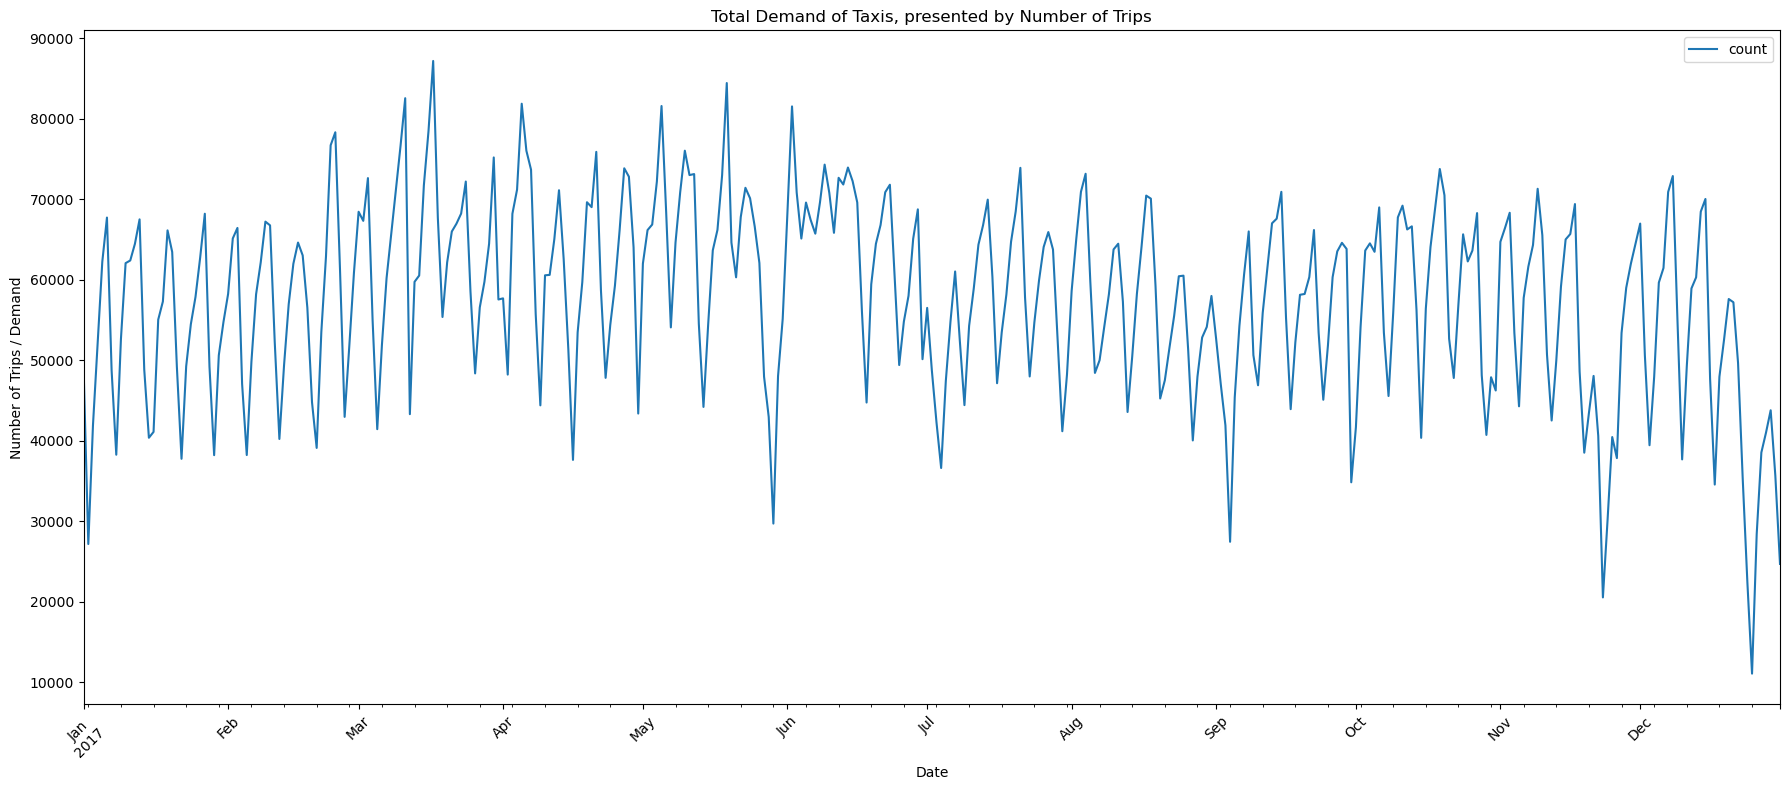

In [9]:
#Plotting aggregated demand data
trip_counts_date.plot(x='trip_start_date', y='count', kind='line', figsize=(18,8)) 
plt.xlabel('Date')
plt.ylabel('Number of Trips / Demand')
plt.title('Total Demand of Taxis, presented by Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4.1.1.2 Impact of Temperature on Demand

In [10]:
# importing weatherdata
weather_df = pd.read_csv('./data/weather_data_final.csv')

In [11]:
weather_df.head()

,date,time,temp,dew_point,humidity,wind_speed,wind_gust,pressure,precip,condition,date_time
0,2017-01-01,00:53,33 °F,24 °F,70 °%,8 °mph,0 °mph,29.45 °in,0.0 °in,Partly Cloudy,2017-01-01 00:53:00
1,2017-01-01,01:53,25 °F,18 °F,75 °%,3 °mph,0 °mph,29.33 °in,0.0 °in,Fair,2017-01-01 01:53:00
2,2017-01-01,02:53,25 °F,18 °F,75 °%,0 °mph,0 °mph,29.34 °in,0.0 °in,Fair,2017-01-01 02:53:00
3,2017-01-01,03:53,25 °F,19 °F,78 °%,5 °mph,0 °mph,29.36 °in,0.0 °in,Fair,2017-01-01 03:53:00
4,2017-01-01,04:53,24 °F,18 °F,77 °%,7 °mph,0 °mph,29.37 °in,0.0 °in,Fair,2017-01-01 04:53:00


In [12]:
#Drop unuseful columns
weather_df.drop(['humidity', 'dew_point', 'wind_speed', 'wind_gust', 'pressure'], axis =1, inplace = True)

In [13]:
#calculate average temps and precips for the date
weather_daily = weather_df[['date', 'temp', 'precip', 'date_time', 'condition']]

In [14]:
# removing units to enable calculations
weather_daily = weather_daily.copy()
weather_daily['temp'] = weather_daily.loc[:, 'temp'].astype(str)
weather_daily.loc[:,'temp'] = weather_daily['temp'].astype(str).str.strip(' °F').astype(float)

In [15]:
# Calculate mean temperature for every day of the year
weather_daily = weather_daily.groupby(['date'])['temp'].mean()
weather_daily = weather_daily.reset_index()

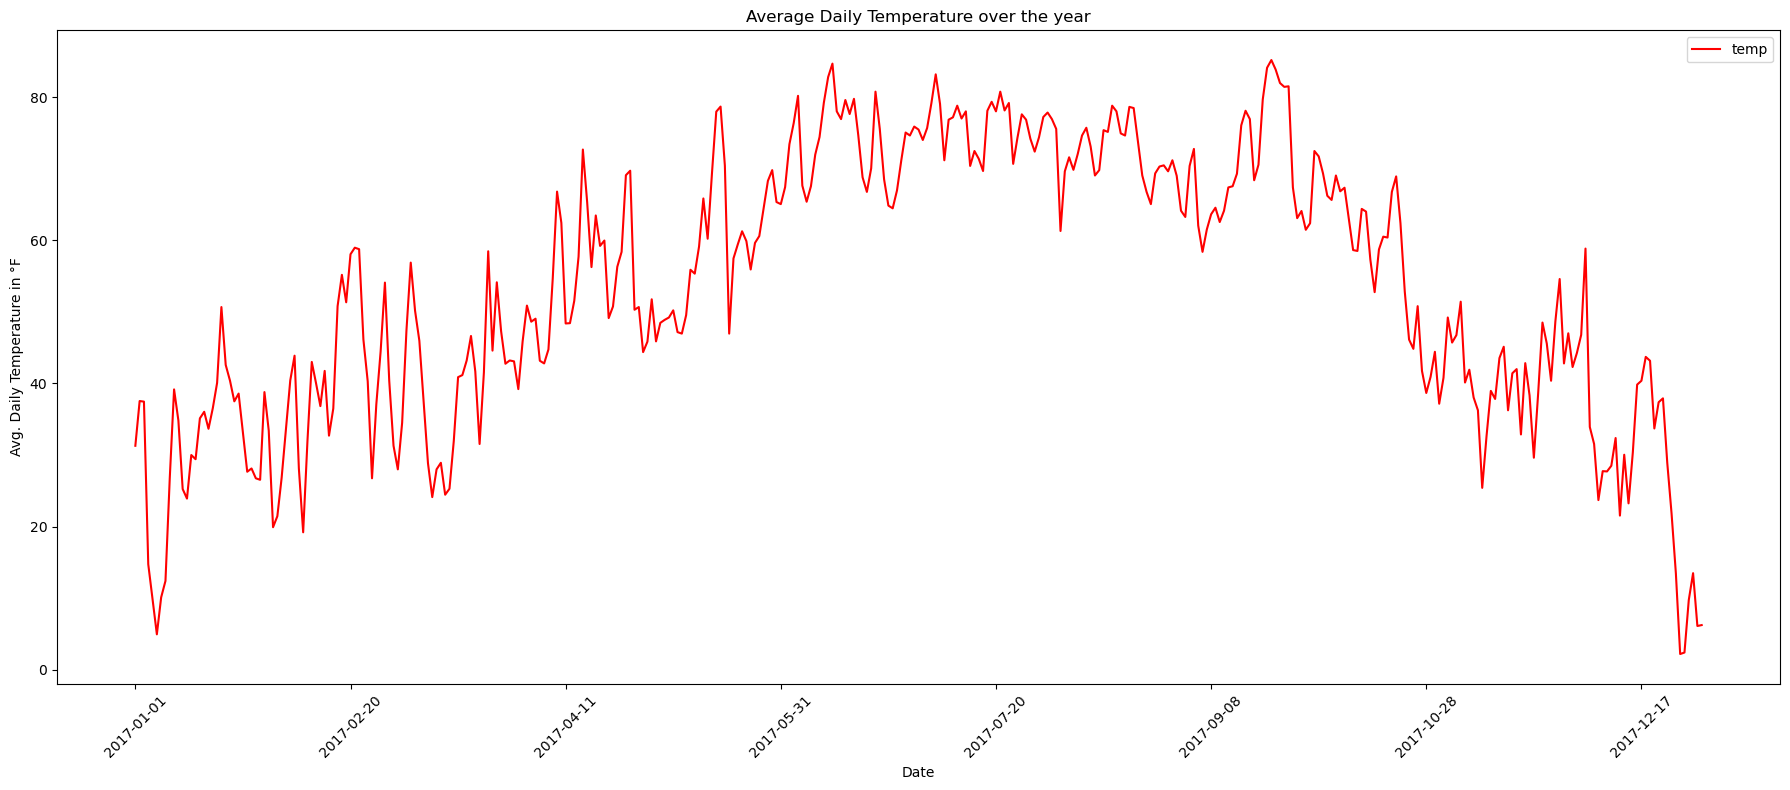

In [16]:
# Plot average temperature

weather_daily.plot(x='date', y='temp', kind='line', color ='red', figsize=(18,8)) 
plt.xlabel('Date')
plt.ylabel('Avg. Daily Temperature in °F')
plt.title('Average Daily Temperature over the year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
weather_daily['date'] = pd.to_datetime(weather_daily['date'])
trip_counts_date['trip_start_date'] = pd.to_datetime(trip_counts_date['trip_start_date'])

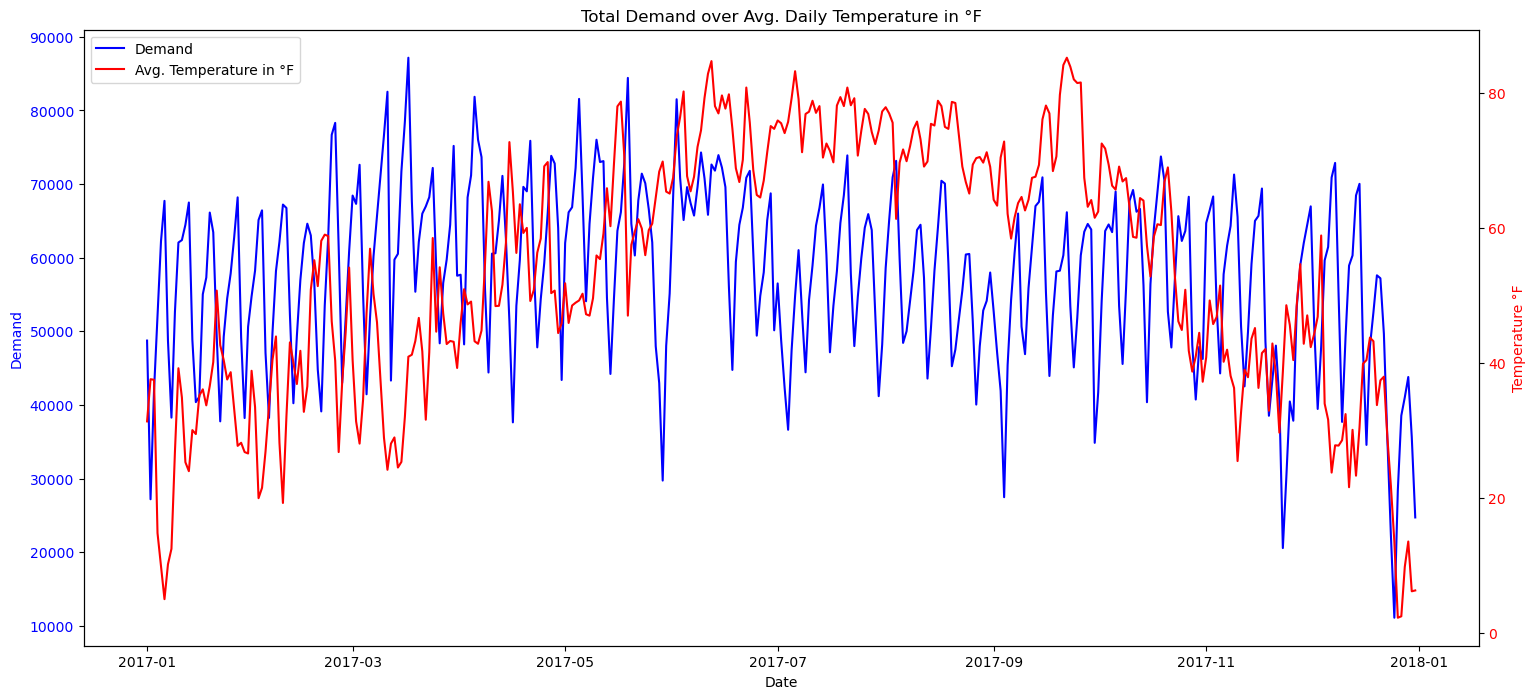

In [18]:
# Plotting aggregated demand and average temperature to visualize behaviors
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='b', label='Demand')
ax1.set_xlabel("Date")
ax1.set_ylabel("Demand", color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(weather_daily['date'], weather_daily['temp'], color='r', label='Avg. Temperature in °F')
ax2.set_ylabel("Temperature °F", color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title("Total Demand over Avg. Daily Temperature in °F")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

In [19]:
# Calculate correlation between temperature and demand, to determine if temperature could be used as a feature to predict demand
correlation = weather_daily['temp'].corr(trip_counts_date['count'])
print(f"Correlation between temperature and demand: {correlation:.2f}")

Correlation between temperature and demand: 0.15


## 4.1.1.3 Impact of weather conditions on Demand

In [20]:
conditions_daily = weather_df[['date','condition']]

In [21]:
# Creating a mapping of all possibel weather conditions to numerical values
#[Fair, Mostly Cloudy, Partly Cloudy, Cloudy, Light Rain, Thunder] => [0,1,2,3,4,5]
conditions_daily = conditions_daily.copy()
conditions_map = {
    "Fair": 0,
    "Mostly Cloudy": 1,
    "Partly Cloudy": 2,
    "Cloudy": 3,
    "Light Rain": 4,
    "Thunder": 5
}

conditions_daily['condition_map'] = conditions_daily['condition'].map(conditions_map)
conditions_daily['condition_map'] = conditions_daily['condition_map'].astype(float)
conditions_daily['date'] = pd.to_datetime(conditions_daily['date'])

In [22]:
# Calculating average weather condition of each day
# round mean of result to maintain the clear mapping of weather conditions

conditions_daily = round(conditions_daily.groupby(['date'])['condition_map'].mean(),0) 
conditions_daily = conditions_daily.reset_index()

In [23]:
conditions_daily.head()

,date,condition_map
0,2017-01-01,1.0
1,2017-01-02,2.0
2,2017-01-03,3.0
3,2017-01-04,1.0
4,2017-01-05,1.0


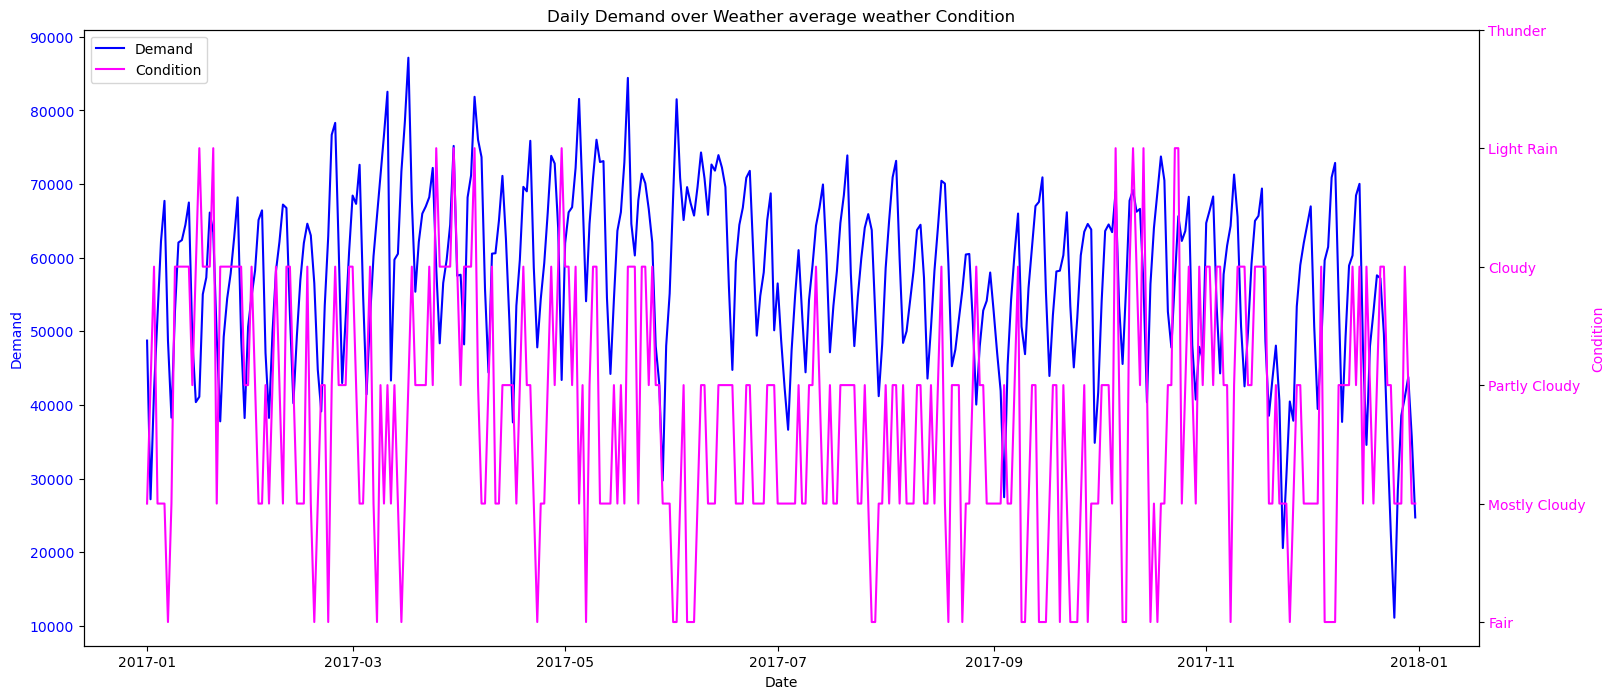

In [24]:
# Plotting average weather conditions of each day over the whol year
# Creating custom array cond_arr, to name the x-axis' ticks to make the visual easier to understand

cond_arr = ['Fair', 'Mostly Cloudy', 'Partly Cloudy', 'Cloudy', 'Light Rain', 'Thunder']
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='b', label='Demand')
ax1.set_xlabel("Date")
ax1.set_ylabel("Demand", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(conditions_daily['date'], conditions_daily['condition_map'], color='magenta', label='Condition')
ax2.set_ylabel("Condition", color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.set_yticks(range(len(cond_arr)))
ax2.set_yticklabels(cond_arr)
plt.title('Daily Demand over Weather average weather Condition')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

In [25]:
# Like with the temperature, calculating correlation between demand and weather condition to assess its capability as predictive feature for demand

merged_data = pd.merge(conditions_daily, trip_counts_date, left_on='date', right_on='trip_start_date', how='inner')
correlation = merged_data['condition_map'].corr(merged_data['count'])
print(f"Correlation between average weather condition and demand: {correlation:.2f}")

Correlation between average weather condition and demand: 0.11


## 4.1.1.4 Impact of precipication on demand

In [26]:
precip_daily = weather_df[['date', 'precip', 'date_time']]

In [27]:
# Again removing untis for calculations
precip_daily = precip_daily.copy()
precip_daily['precip'] = precip_daily['precip'].astype(str).str.strip(' °in').astype(float)
precip_daily['date'] = pd.to_datetime(precip_daily['date'])

In [28]:
# Calculating mean precip for every day of the year
precip_daily = precip_daily.groupby(['date'])['precip'].mean()
precip_daily = precip_daily.reset_index()

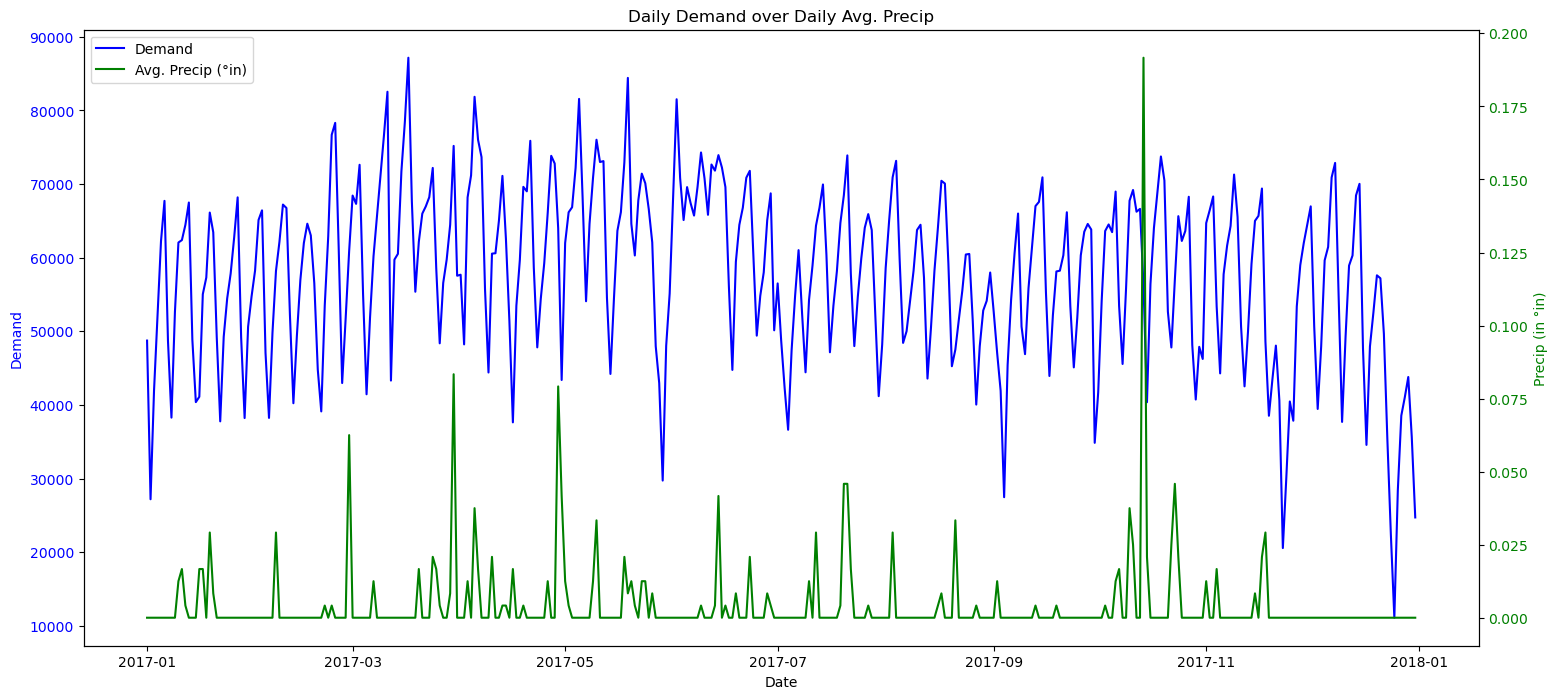

In [29]:
# Plotting average precip of each day over the demand
fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='b', label='Demand')
ax1.set_xlabel("Date")
ax1.set_ylabel("Demand", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(trip_counts_date['trip_start_date'], precip_daily['precip'], color='g', label='Avg. Precip (°in)')
ax2.set_ylabel("Precip (in °in)", color='g')
ax2.tick_params(axis='y', labelcolor='g')
plt.title("Daily Demand over Daily Avg. Precip")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

In [30]:
#Calculating correlation between precip and Demand
merged_data = pd.merge(precip_daily, trip_counts_date, left_on='date', right_on='trip_start_date', how='inner')
correlation = merged_data['precip'].corr(merged_data['count'])
print(f"Correlation between temperature and demand: {correlation:.2f}")

Correlation between temperature and demand: 0.13


## 4.1.1.5 Impact of Holidays on Demand

In [31]:
# Determining if Holidays have an impact on Demand
# All holidays and non-working days in chicago in 2017:
# 01.01, 02.01, 16.01, 20.01, 20.02, 29.05, 04.07, 04.09, 09.10, 10.11, 11.11, 23.11, 25.11
#Source: https://www.timeanddate.com/holidays/us/2017?hol=9

In [32]:
# First turning holidays into strings
holiday_strings = [
    "01.01.2017", "02.01.2017", "16.01.2017", "20.01.2017", "20.02.2017", "29.05.2017",
    "04.07.2017", "04.09.2017", "09.10.2017", "10.11.2017", "11.11.2017", "23.11.2017", "25.11.2017"
]

date_format = "%d.%m.%Y"

#Then turning holidays into dateformat
holidays = [datetime.strptime(date, date_format) for date in holiday_strings]
print(holidays)

[datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 1, 2, 0, 0), datetime.datetime(2017, 1, 16, 0, 0), datetime.datetime(2017, 1, 20, 0, 0), datetime.datetime(2017, 2, 20, 0, 0), datetime.datetime(2017, 5, 29, 0, 0), datetime.datetime(2017, 7, 4, 0, 0), datetime.datetime(2017, 9, 4, 0, 0), datetime.datetime(2017, 10, 9, 0, 0), datetime.datetime(2017, 11, 10, 0, 0), datetime.datetime(2017, 11, 11, 0, 0), datetime.datetime(2017, 11, 23, 0, 0), datetime.datetime(2017, 11, 25, 0, 0)]


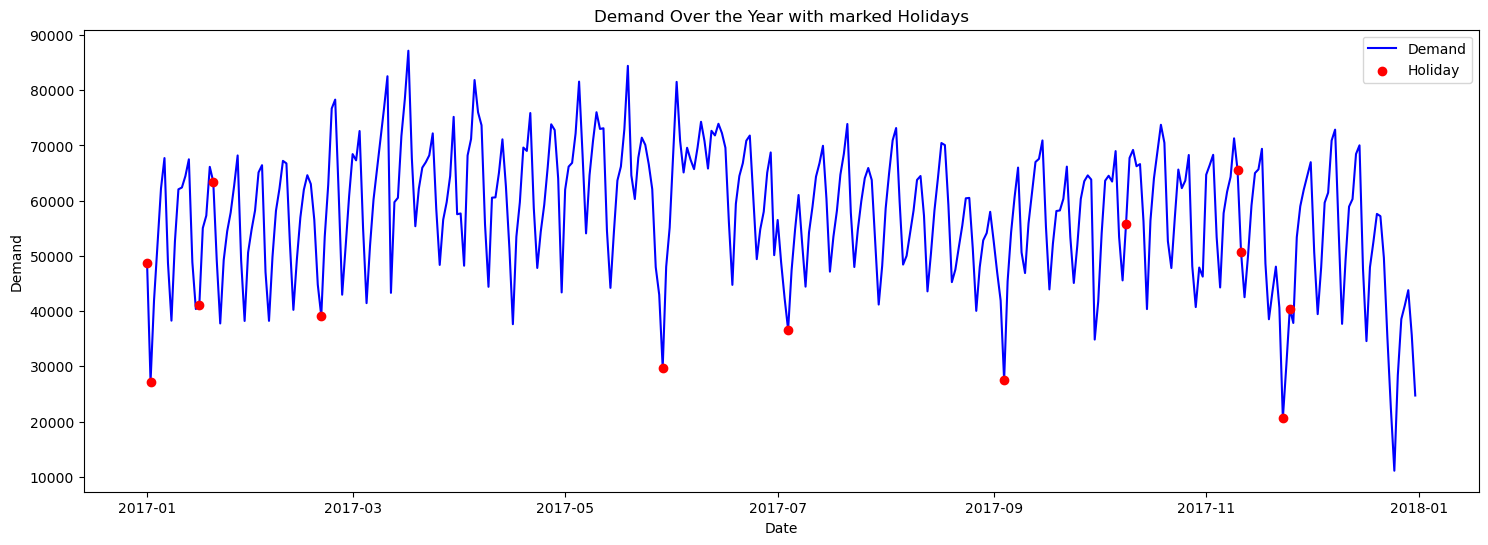

In [33]:
# Marking holidays on Demand curve, using red markers
plt.figure(figsize=(18, 6))
plt.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], linestyle='-', color='blue', label='Demand')

legend = True
for holiday in holidays:
    label = 'Holiday' if legend else None
    plt.scatter(holiday, trip_counts_date[trip_counts_date['trip_start_date'] == holiday]['count'], color='red', zorder=5, label=label)
    legend = False
    
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand Over the Year with marked Holidays")
plt.legend()

plt.show()

In [34]:
#create isHoliday attribute to check for correlation later
def isHoliday(date):
    return date in holidays

trip_counts_date['isHoliday'] = trip_counts_date['trip_start_date'].apply(isHoliday)

In [35]:
# utilizing isHoliday method, calculate correlation of demand with days being hoidays
correlation = trip_counts_date['isHoliday'].corr(trip_counts_date['count'])
print(f"Correlation between Holidays and demand: {correlation:.2f}")

Correlation between Holidays and demand: -0.26


In [36]:
# Calculating average demand on holidays and non-holidays to compare
avg = trip_counts_date.groupby('isHoliday')['count'].mean()
print(avg)

isHoliday
False    58333.082386
True     42040.307692
Name: count, dtype: float64


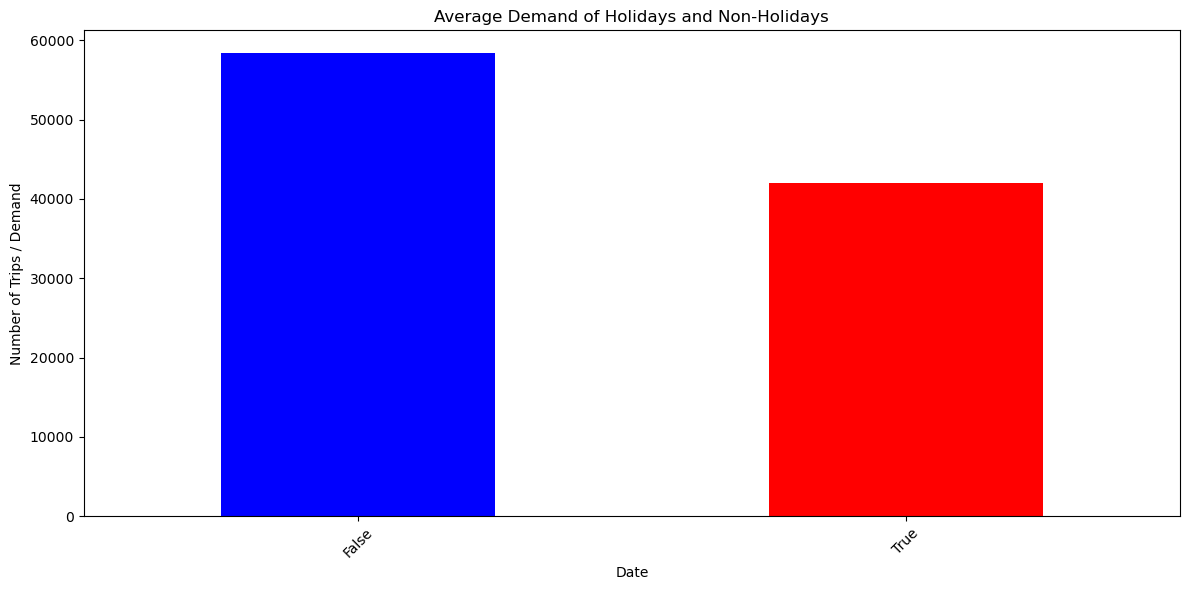

In [37]:
# Plotting Demand on non-holiday days and holiday-days
avg.plot(x='isHoliday', y='count', kind='bar', figsize=(12,6), color = ['blue','red']) 
plt.xlabel('Date')
plt.ylabel('Number of Trips / Demand')
plt.title('Average Demand of Holidays and Non-Holidays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4.1.1.6 Impact of Weekends on Demand


In [38]:
# Checking if weekend have an impact on demand
trip_counts_date['isWeekend'] = trip_counts_date['trip_start_date'].dt.dayofweek >= 5

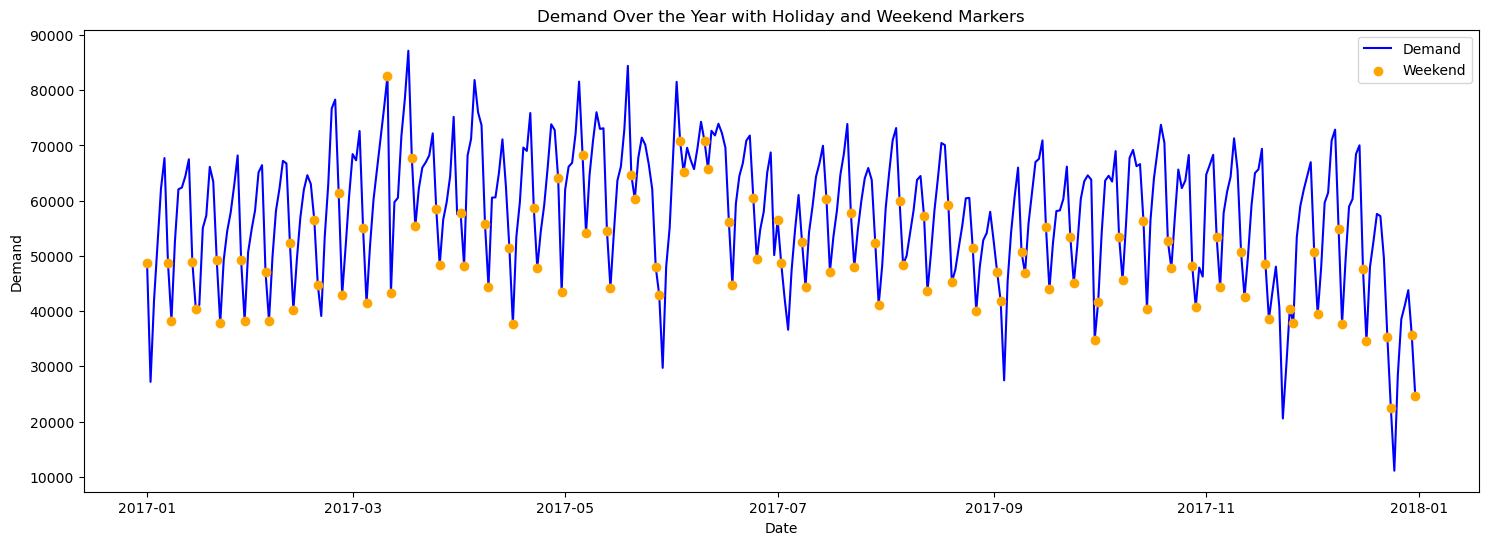

In [39]:
# Similar to the Holiday-Feature, first each day gets a new column "isWeekend", which is of boolean value and True
# if the day is a weekend-day and not, if it is a weekday. 
# Then, again the demand curved is plotted, with the weekend-days marked with yellow markers

plt.figure(figsize=(18, 6))
plt.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], linestyle='-', color='blue', label='Demand')

legend = True
for index, row in trip_counts_date.iterrows():
    if row['isWeekend']:
        label = 'Weekend' if legend else None
        plt.scatter(row['trip_start_date'], row['count'], color='orange', zorder=5, label=label)
        legend = False
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand Over the Year with Holiday and Weekend Markers")
plt.legend()

plt.show()

In [40]:
# Calculating average demand on weekdays and weekends
avg = trip_counts_date.groupby('isWeekend')['count'].mean()
avg = avg.reset_index()
print(avg)

   isWeekend         count
0      False  61215.192308
1       True  49179.228571


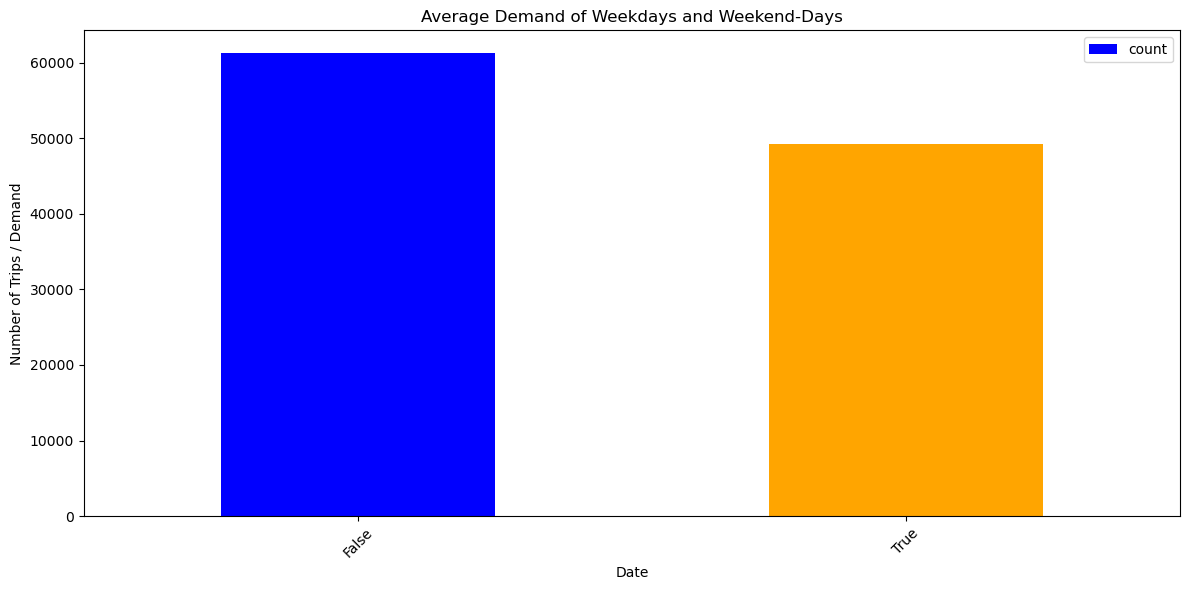

In [41]:
# Plotting average demand differences between weekdays and weekends
avg.plot(x='isWeekend', y='count', kind='bar', figsize=(12,6), color = ['blue','orange']) 
plt.xlabel('Date')
plt.ylabel('Number of Trips / Demand')
plt.title('Average Demand of Weekdays and Weekend-Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Calculating correlation between a day being a weekend-day and demand
correlation = trip_counts_date['isWeekend'].corr(trip_counts_date['count'])
print(f"Correlation between Weekends and demand: {correlation:.2f}")

Correlation between Weekends and demand: -0.46


## 4.1.1.7 Weekdays on Demand Curve

In [43]:
# Create Weekday column in trip_counts_date dataframe to inspect if demand changes with the day of Week
# 0 = Monday -> 6 = Sunday
trip_counts_date['weekday'] = trip_counts_date['trip_start_date'].dt.dayofweek

In [44]:
trip_counts_date.head()

,trip_start_date,count,isHoliday,isWeekend,weekday
0,2017-01-01,48738,True,True,6
1,2017-01-02,27182,True,False,0
2,2017-01-03,41944,False,False,1
3,2017-01-04,52079,False,False,2
4,2017-01-05,62229,False,False,3


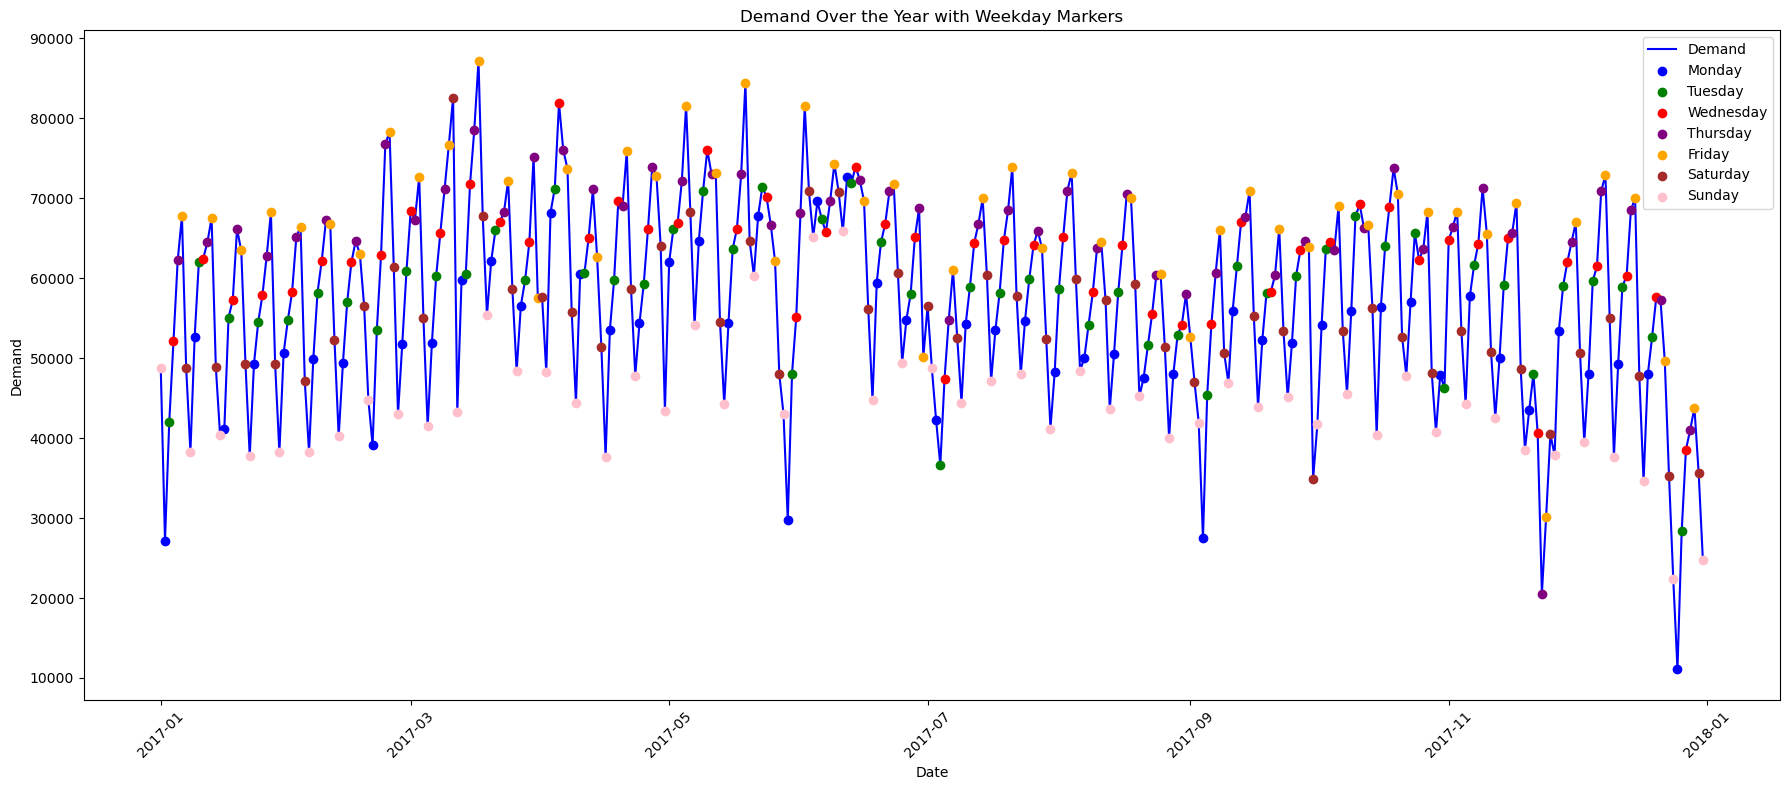

In [45]:
# Create a color mapping for weekdays and then mark every weekday with the assigned color on the demand curve
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

plt.figure(figsize=(18, 8))
plt.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], linestyle='-', color='blue', label='Demand')

# color indexing is the same as weekday indexing
for weekday in range(7):
    weekday_data = trip_counts_date[trip_counts_date['weekday'] == weekday]
    plt.scatter(weekday_data['trip_start_date'], weekday_data['count'], color=colors[weekday], zorder=5, label=weekdays[weekday])

plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand Over the Year with Weekday Markers")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# Again calculating the correlation of Weekday and demand
correlation = trip_counts_date['weekday'].corr(trip_counts_date['count'])
print(f"Correlation between the Weekday and demand: {correlation:.2f}")

Correlation between the Weekday and demand: -0.16


## 4.1.1.8 General Demand Proportion of Weekdays

In [47]:
# Proportion of Demand of each weekday (in total)
trip_counts_weekday = trip_counts_date.groupby('weekday')['count'].sum()
trip_counts_weekday = trip_counts_weekday.reset_index()
# Calculating total demand to use as reference and for calculation
total_demand = trip_counts_date['count'].sum()

In [48]:
print(total_demand)

21079769


In [49]:
# calculating proportion of demand with respect to weekday
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trip_counts_weekday['weekday_name'] = trip_counts_weekday['weekday'].map(lambda x: weekday_names[x])
trip_counts_weekday['proportion'] = trip_counts_weekday['count'].apply(lambda x: x/total_demand)

In [50]:
trip_counts_weekday.head(20)

,weekday,count,weekday_name,proportion
0,0,2681154,Monday,0.127191
1,1,3025875,Tuesday,0.143544
2,2,3260751,Wednesday,0.154686
3,3,3439628,Thursday,0.163172
4,4,3508542,Friday,0.166441
5,5,2834795,Saturday,0.134479
6,6,2329024,Sunday,0.110486


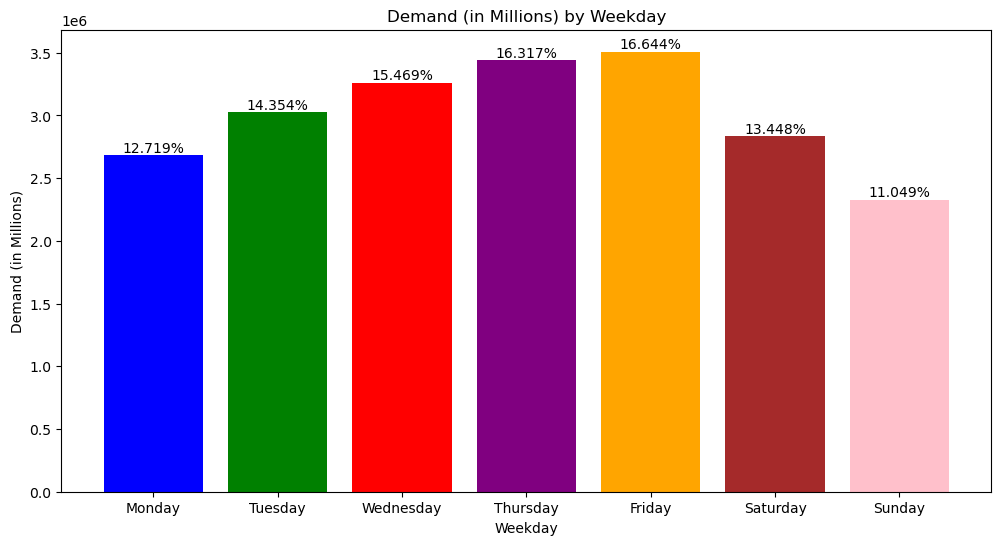

In [51]:
# Plotting demand proportions of weekdays, with also displaying their respective percentages
plt.figure(figsize=(12, 6))
bars = plt.bar(trip_counts_weekday['weekday_name'], trip_counts_weekday['count'], color=colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{round(bar.get_height() / total_demand * 100, 3)}%", ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Weekday')
plt.ylabel('Demand (in Millions)')
plt.title('Demand (in Millions) by Weekday')
plt.show()

## 4.1.1.9 Seasonal Demand proportion of Weekdays

In [52]:
#Starting off, by Mapping the Months to the season
seasons_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
trip_counts_date['season'] = trip_counts_date['trip_start_date'].dt.month.map(seasons_map)

#Customizing weekday-name mapping so it loops over whole dataset and not only one instance of weekday each, as previously done due to aggregation on weekday
weekday_names = {0: 'Monday',1: 'Tuesday',2: 'Wednesday',3: 'Thursday',4: 'Friday',5: 'Saturday',6: 'Sunday'}
trip_counts_date['weekday_name'] = trip_counts_date['weekday'].apply(lambda x: weekday_names[x])

In [53]:
trip_counts_date.head()

,trip_start_date,count,isHoliday,isWeekend,weekday,season,weekday_name
0,2017-01-01,48738,True,True,6,Winter,Sunday
1,2017-01-02,27182,True,False,0,Winter,Monday
2,2017-01-03,41944,False,False,1,Winter,Tuesday
3,2017-01-04,52079,False,False,2,Winter,Wednesday
4,2017-01-05,62229,False,False,3,Winter,Thursday


In [54]:
# Calculating the general demand of every season
season_demand = trip_counts_date.groupby(['season'])['count'].sum().reset_index()

In [55]:
season_demand.head(10)

,season,count
0,Fall,5066487
1,Spring,5802536
2,Summer,5476007
3,Winter,4734739


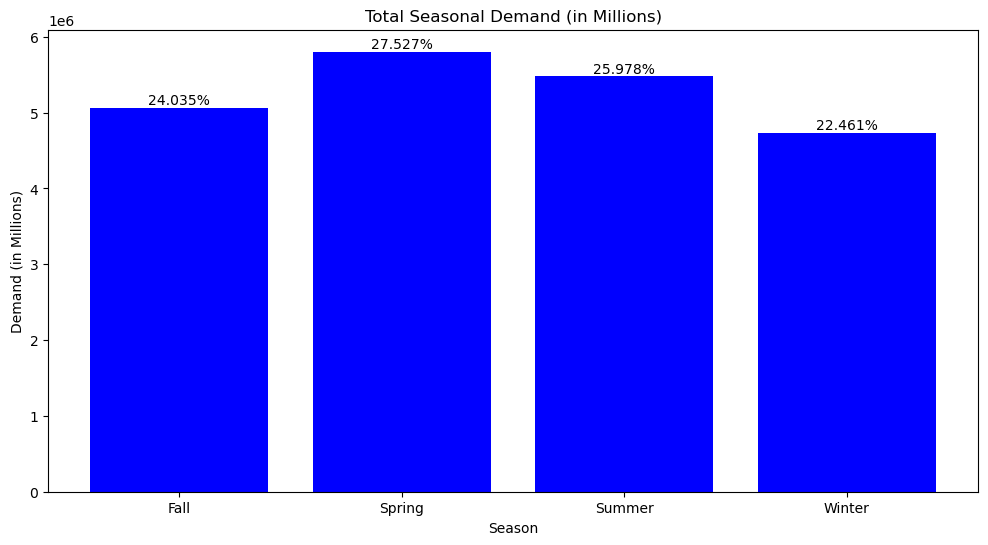

In [56]:
#Plotting Demand Proportions of each season
plt.figure(figsize=(12, 6))
bars = plt.bar(season_demand['season'], season_demand['count'], color='blue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{round(bar.get_height() / total_demand * 100, 3)}%", ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Season')
plt.ylabel('Demand (in Millions)')
plt.title('Total Seasonal Demand (in Millions)')
plt.show()

In [57]:
#Calculating the demand for every weekday for all seasons
season_weekday_demand = trip_counts_date.groupby(['season', 'weekday_name'])['count'].sum().reset_index()

In [58]:
season_weekday_demand.head()

,season,weekday_name,count
0,Fall,Friday,827382
1,Fall,Monday,663291
2,Fall,Saturday,644951
3,Fall,Sunday,557166
4,Fall,Thursday,808676


In [59]:
#Sorting dataframe from Monday to Sunday in order to maintain uniform color code of weekdays
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'weekday_name' column to categorical to enable sorting with custom order
season_weekday_demand['weekday_name'] = pd.Categorical(season_weekday_demand['weekday_name'], categories=custom_order, ordered=True)
season_weekday_demand.sort_values(by=['season', 'weekday_name'])

,season,weekday_name,count
1,Fall,Monday,663291
5,Fall,Tuesday,760455
6,Fall,Wednesday,804566
4,Fall,Thursday,808676
0,Fall,Friday,827382
2,Fall,Saturday,644951
3,Fall,Sunday,557166
8,Spring,Monday,745419
12,Spring,Tuesday,817328
13,Spring,Wednesday,954186


In [60]:
# create pivot dataframe of seasons and weekdays
pivot_season = season_weekday_demand.pivot(index='season', columns='weekday_name', values='count')

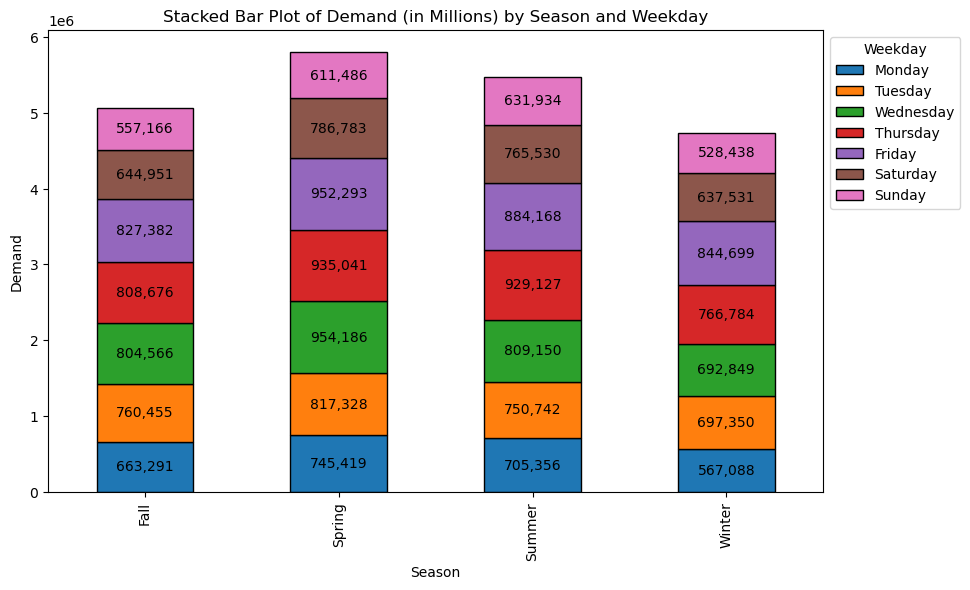

In [61]:
# Creating a stacked bar plot, of each season, with the proportion of the demand of each weekday being displayed
# Previously determined color code for weekdays is kept

ax = pivot_season.plot(kind='bar', stacked=True, figsize=(10, 6))
for container in ax.containers:
    plt.setp(container, edgecolor='black')
    for rect in container.patches:
        width = rect.get_width()
        height = rect.get_height()
        x = rect.get_x()
        y = rect.get_y()
        ax.text(x + width / 2, y + height / 2, f'{int(height):,}', ha='center', va='center', color='black')

plt.xlabel('Season')
plt.ylabel('Demand')
plt.title('Stacked Bar Plot of Demand (in Millions) by Season and Weekday')
plt.legend(title='Weekday', bbox_to_anchor=(1, 1))

plt.show()

## 4.1.1.10 Monthly Demand proportion of Weekdays

In [62]:
trip_counts_date['month'] = trip_counts_date['trip_start_date'].dt.month

In [63]:
trip_counts_date.head()

,trip_start_date,count,isHoliday,isWeekend,weekday,season,weekday_name,month
0,2017-01-01,48738,True,True,6,Winter,Sunday,1
1,2017-01-02,27182,True,False,0,Winter,Monday,1
2,2017-01-03,41944,False,False,1,Winter,Tuesday,1
3,2017-01-04,52079,False,False,2,Winter,Wednesday,1
4,2017-01-05,62229,False,False,3,Winter,Thursday,1


In [64]:
month_demand = trip_counts_date.groupby(['month'])['count'].sum().reset_index()

In [65]:
# Create mapping, which maps month indices to month names for better visual representation

months_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
month_demand['month_name'] = month_demand['month'].map(months_map)

In [66]:
month_demand.head(12)

,month,count,month_name
0,1,1640497,January
1,2,1596548,February
2,3,1992822,March
3,4,1853859,April
4,5,1955855,May
5,6,1970048,June
6,7,1740773,July
7,8,1765186,August
8,9,1647556,September
9,10,1811680,October


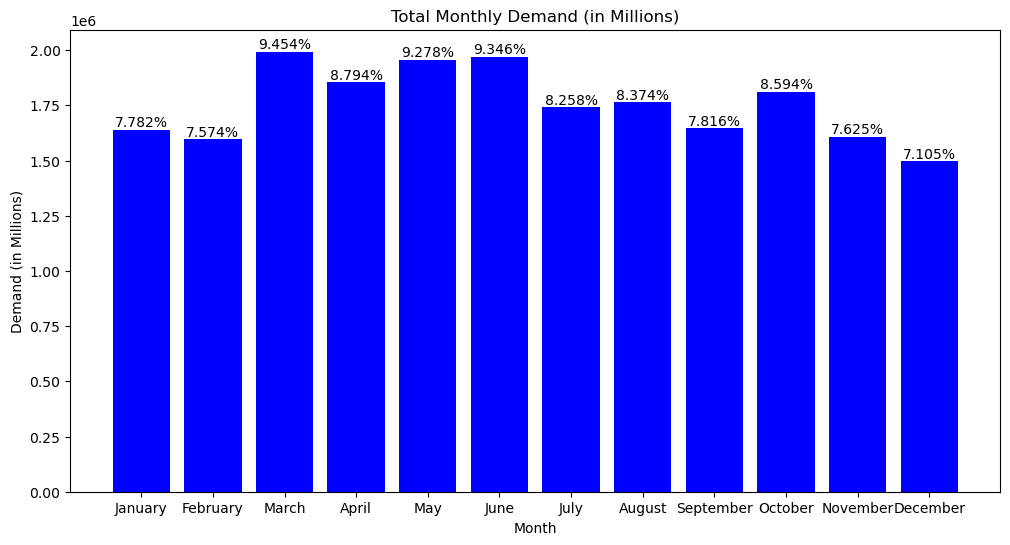

In [67]:
# Ploting the demand of every month, while also presenting each month's proportion of the total demand
plt.figure(figsize=(12, 6))
bars = plt.bar(month_demand['month_name'], month_demand['count'], color='blue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{round(bar.get_height() / total_demand * 100, 3)}%", ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Month')
plt.ylabel('Demand (in Millions)')
plt.title('Total Monthly Demand (in Millions)')
plt.show()

In [68]:
correlation = trip_counts_date['month'].corr(trip_counts_date['count'])
print(f"Correlation between the Month and Demand: {correlation:.2f}")

Correlation between the Month and Demand: -0.19


In [69]:
# creating a dataframe, which will track the demand of weekdays, within different months
month_weekday_demand = trip_counts_date.groupby(['month', 'weekday_name'])['count'].sum().reset_index()
months_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
month_weekday_demand['month_name'] = month_weekday_demand['month'].map(months_map)

#Again sorting after custom order
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'weekday_name' column to categorical to enable sorting with custom order
month_weekday_demand['weekday_name'] = pd.Categorical(month_weekday_demand['weekday_name'], categories=custom_order, ordered=True)
month_weekday_demand.sort_values(by=['month_name', 'weekday_name'])

,month,weekday_name,count,month_name
22,4,Monday,236596,April
26,4,Tuesday,250762,April
27,4,Wednesday,282637,April
25,4,Thursday,289987,April
21,4,Friday,284926,April
...,...,...,...,...
62,9,Wednesday,243029,September
60,9,Thursday,253131,September
56,9,Friday,319594,September
58,9,Saturday,241239,September


In [70]:
# Again utilizing a pivot dataframe to assign weekday demands to months
pivot_month = month_weekday_demand.pivot(index='month', columns='weekday_name', values='count')

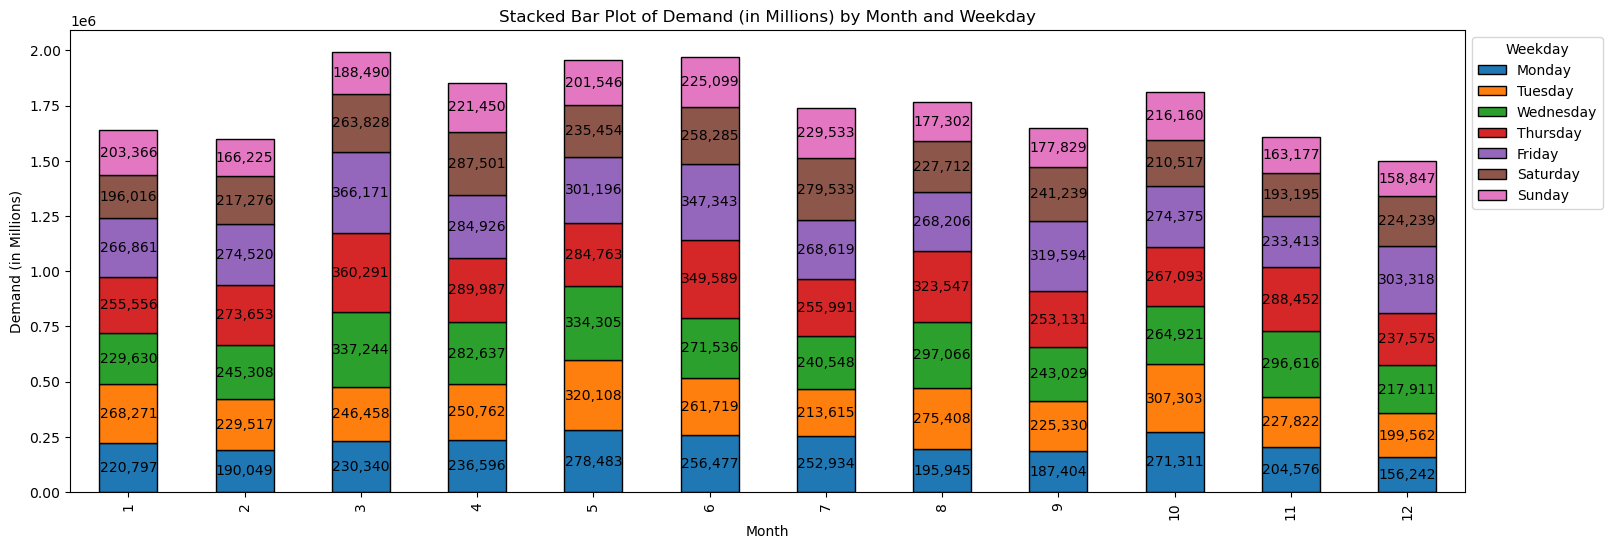

In [71]:
#Creating stacked bar chart of demand of individual weekdays within all months of the year
ax = pivot_month.plot(kind='bar', stacked=True, figsize=(18, 6))
for container in ax.containers:
    plt.setp(container, edgecolor='black')
    for rect in container.patches:
        width = rect.get_width()
        height = rect.get_height()
        x = rect.get_x()
        y = rect.get_y()
        ax.text(x + width / 2, y + height / 2, f'{int(height):,}', ha='center', va='center', color='black')

plt.xlabel('Month')
plt.ylabel('Demand (in Millions)')
plt.title('Stacked Bar Plot of Demand (in Millions) by Month and Weekday')
plt.legend(title='Weekday', bbox_to_anchor=(1, 1))

plt.show()

## 4.1.1.11 Hourly Demand Patterns

In [72]:
# Since we not only want to except the total demand, also the hourly demand, we do that here
# Every inspection scope of the total demand will also be applied here

df_hourly = df[['trip_id','trip_start_date','trip_start_hour']]

In [73]:
# Creating hourly demand over whole dataset
count_hourly_total = df_hourly.groupby(by='trip_start_hour').agg({'count': vaex.agg.count('trip_id')}) 

In [74]:
#Converting hour index to actual time for better presentation
count_hourly_total = count_hourly_total.to_pandas_df()
count_hourly_total['hour_format'] = count_hourly_total['trip_start_hour'].apply(lambda x: f'{x:02d}:00')

In [75]:
count_hourly_total.head()

,trip_start_hour,count,hour_format
0,0,608193,00:00
1,1,500091,01:00
2,2,396749,02:00
3,3,296660,03:00
4,4,211405,04:00


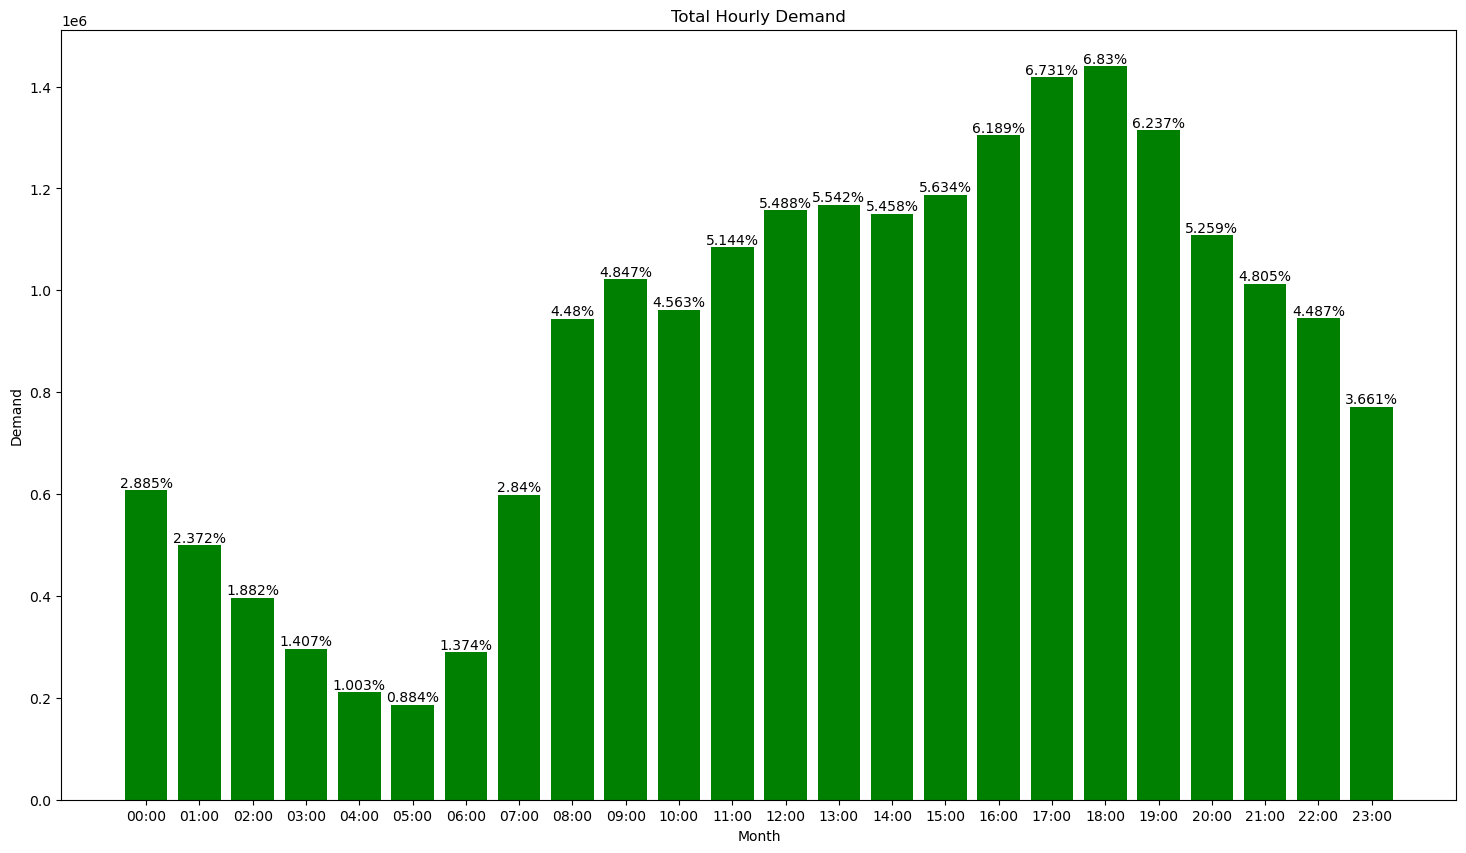

In [76]:
# Plotting Demand of every hour the day, while also presenting proportions of demand
plt.figure(figsize=(18, 10))
bars = plt.bar(count_hourly_total['hour_format'], count_hourly_total['count'], color='green')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{round(bar.get_height() / total_demand * 100, 3)}%", ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Total Hourly Demand')
plt.show()

## 4.1.1.12 Impact of Weekends on Hourly Demand

In [77]:
# Again creating new column which resembles if day is a weekend day or not
df_hourly['isWeekend'] = df_hourly['trip_start_date'].dt.dayofweek >= 5

In [78]:
df_hourly.head(25000)

#,trip_id,trip_start_date,trip_start_hour,isWeekend
0,f00546971a3e4c8ab55761a337443a0dfa33f42f,2017-01-01,0,True
1,fe9bfc25af9dffac30370f4e7d57a8c8a8bdbc0d,2017-01-01,0,True
2,149f18c2d8b9bce6001cc9e156092aa562c83bc1,2017-01-01,0,True
3,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,2017-01-01,0,True
4,f398f04efdae9641df780e0a824770a62ab9a2ea,2017-01-01,0,True
...,...,...,...,...
"24,995",60fdc438da22df4bab96ae8544c771a4707c60c5,2017-01-01,8,True
"24,996",79f94ca8b1bfcf22979f9a7d24b93186e547ecbd,2017-01-01,8,True
"24,997",66b3cdd66d409245606988f9fbe652bce4a9537f,2017-01-01,8,True
"24,998",3a98d30213255cbde72bc566d946767491000562,2017-01-01,8,True


In [79]:
# aggregate demand of weekend days and non-weekend days
count_hourly_weekend = df_hourly.groupby(by=['trip_start_hour','isWeekend']).agg({'count': vaex.agg.count('trip_id')}) 

In [80]:
count_hourly_weekend = count_hourly_weekend.to_pandas_df()

In [81]:
count_hourly_weekend.head()

,trip_start_hour,isWeekend,count
0,0,False,283993
1,0,True,324200
2,1,False,186927
3,1,True,313164
4,2,False,125687


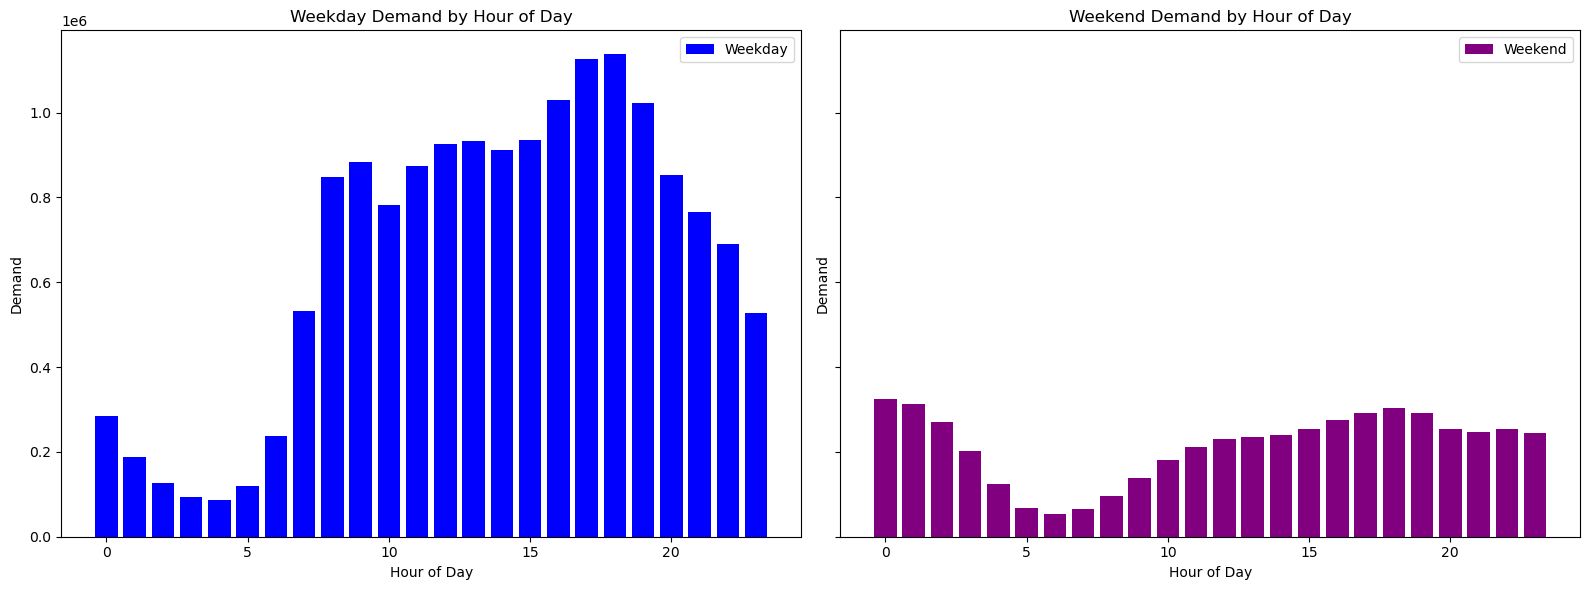

In [82]:
# seperating weekend and weekday data using previously created column
# Plotting demand of weekday-hours and weekend-hours 
weekday_data = count_hourly_weekend[count_hourly_weekend['isWeekend'] == False]
weekend_data = count_hourly_weekend[count_hourly_weekend['isWeekend'] == True]

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
axs[0].bar(weekday_data['trip_start_hour'], weekday_data['count'], color='b', label='Weekday')
axs[0].set_title('Weekday Demand by Hour of Day')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Demand')
axs[0].legend()

axs[1].bar(weekend_data['trip_start_hour'], weekend_data['count'], color='purple', label='Weekend')
axs[1].set_title('Weekend Demand by Hour of Day')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Demand')
axs[1].legend()

plt.tight_layout()
plt.show()

## 4.1.1.13 Impact of Rushhour on hourly Demand

In [83]:
#Typical rushhour: 06:00-08:00 and 16:00-18:00
# Creating isRushhour column
count_hourly_total['isRushhour'] = count_hourly_total['trip_start_hour'].apply(lambda x: True if (x >= 6 and x <= 8) or (x >= 16 and x <= 18) else False)

In [84]:
count_hourly_total.head()

,trip_start_hour,count,hour_format,isRushhour
0,0,608193,00:00,False
1,1,500091,01:00,False
2,2,396749,02:00,False
3,3,296660,03:00,False
4,4,211405,04:00,False


In [85]:
# Calculating rush-hour and non-rushhour total deamdn
rushhour_demand = count_hourly_total.groupby('isRushhour')['count'].sum().reset_index()
total_demaand = count_hourly_total['count'].sum()

In [86]:
rushhour_demand.head()

,isRushhour,count
0,False,15084058
1,True,5995711


In [87]:
# Calculating proportions of rush-hour and non-rush-hour demand
print('Percentage of Rushhour-Demand of Total Demand:', (rushhour_demand[rushhour_demand['isRushhour'] == True]['count'].sum()) / total_demand * 100, '%')
print('Percentage of non-Rushhour-Demand of Total Demand:', (rushhour_demand[rushhour_demand['isRushhour'] == False]['count'].sum()) / total_demand * 100, '%')

Percentage of Rushhour-Demand of Total Demand: 28.442963487882622 %
Percentage of non-Rushhour-Demand of Total Demand: 71.55703651211738 %


In [88]:
# Calculting correlation of rush-hour with demand
correlation = count_hourly_total['isRushhour'].corr(trip_counts_date['count'])
print(f"Correlation between the Rushhour and demand: {correlation:.2f}")

Correlation between the Rushhour and demand: 0.03


## 4.1.1.14 Impact of Temperature on hourly Demand

In [89]:
weather_df.head()

,date,time,temp,precip,condition,date_time
0,2017-01-01,00:53,33 °F,0.0 °in,Partly Cloudy,2017-01-01 00:53:00
1,2017-01-01,01:53,25 °F,0.0 °in,Fair,2017-01-01 01:53:00
2,2017-01-01,02:53,25 °F,0.0 °in,Fair,2017-01-01 02:53:00
3,2017-01-01,03:53,25 °F,0.0 °in,Fair,2017-01-01 03:53:00
4,2017-01-01,04:53,24 °F,0.0 °in,Fair,2017-01-01 04:53:00


In [90]:
#copy weather_df
hourly_weather = weather_df.copy()

#bring time into hourly format to enable merge with hourly demand dataframe
hourly_weather['hourly_time'] = pd.to_datetime(hourly_weather['date_time']).dt.strftime('%H:00')
hourly_weather.drop(['time', 'date_time'], axis=1)

#Remove units of precip and temp to enable calculations - same as above
hourly_weather = hourly_weather.copy()
hourly_weather['temp'] = hourly_weather.loc[:, 'temp'].astype(str)
hourly_weather.loc[:,'temp'] = hourly_weather['temp'].astype(str).str.strip(' °F').astype(float)

hourly_weather['precip'] = hourly_weather['precip'].astype(str).str.strip(' °in').astype(float)
hourly_weather['date'] = pd.to_datetime(hourly_weather['date'])

#Map weather conditions same way it was done earlier
hourly_weather['condition_map'] = hourly_weather['condition'].map(conditions_map)
hourly_weather['condition_map'] = hourly_weather['condition_map'].astype(float)

#Mapping seasons for every date

In [91]:
hourly_weather.head(50)

,date,time,temp,precip,condition,date_time,hourly_time,condition_map
0,2017-01-01,00:53,33.0,0.0,Partly Cloudy,2017-01-01 00:53:00,00:00,2.0
1,2017-01-01,01:53,25.0,0.0,Fair,2017-01-01 01:53:00,01:00,0.0
2,2017-01-01,02:53,25.0,0.0,Fair,2017-01-01 02:53:00,02:00,0.0
3,2017-01-01,03:53,25.0,0.0,Fair,2017-01-01 03:53:00,03:00,0.0
4,2017-01-01,04:53,24.0,0.0,Fair,2017-01-01 04:53:00,04:00,0.0
5,2017-01-01,05:53,22.0,0.0,Fair,2017-01-01 05:53:00,05:00,0.0
6,2017-01-01,06:53,22.0,0.0,Cloudy,2017-01-01 06:53:00,06:00,3.0
7,2017-01-01,07:53,22.0,0.0,Cloudy,2017-01-01 07:53:00,07:00,3.0
8,2017-01-01,08:53,22.0,0.0,Cloudy,2017-01-01 08:53:00,08:00,3.0
9,2017-01-01,09:53,26.0,0.0,Fair,2017-01-01 09:53:00,09:00,0.0


In [92]:
# aggregate mean temperature of whole year on hourly basis
mean_temp_hourly = hourly_weather.groupby(['hourly_time'])['temp'].mean().reset_index()

In [93]:
mean_temp_hourly.head()

,hourly_time,temp
0,00:00,50.997260
1,01:00,50.501370
2,02:00,49.868493
3,03:00,49.323288
4,04:00,48.791781


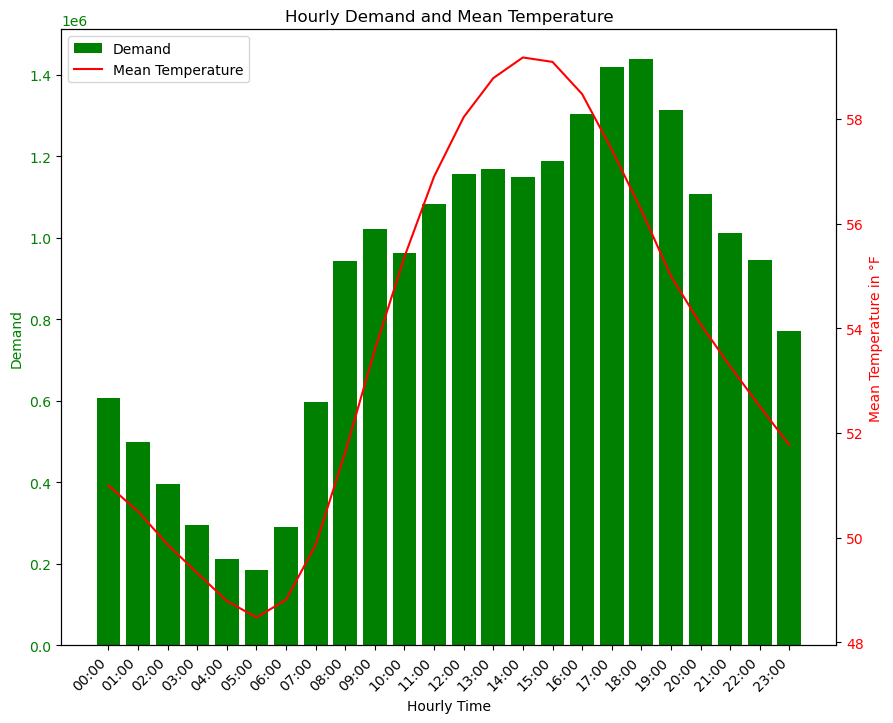

In [94]:
# Plot mean temperature over mean hourly demand
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.bar(count_hourly_total['hour_format'], count_hourly_total['count'], color='green', label='Demand')
ax1.set_xlabel('Hourly Time')
ax1.set_ylabel('Demand', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()

ax2.plot(mean_temp_hourly['hourly_time'], mean_temp_hourly['temp'], color='r', label='Mean Temperature')
ax2.set_ylabel('Mean Temperature in °F', color='r')
ax2.tick_params(axis='y', labelcolor='r')

xticks = range(len(count_hourly_total['hour_format']))
ax1.set_xticks(xticks)
ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45, ha='right')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=70)
plt.title('Hourly Demand and Mean Temperature')
plt.show()

In [95]:
# Calculate correlation of mean temperature with hourly deamnd
correlation = mean_temp_hourly['temp'].corr(count_hourly_total['count'])
print(f"Correlation between the hourly temperature and hourly demand: {correlation:.2f}")

Correlation between the hourly temperature and hourly demand: 0.89


## 4.1.1.15 Impact of Precipitation on Hourly Demand

In [96]:
# calculate average hourly precip
mean_precip_hourly = hourly_weather.groupby(['hourly_time'])['precip'].mean().reset_index()

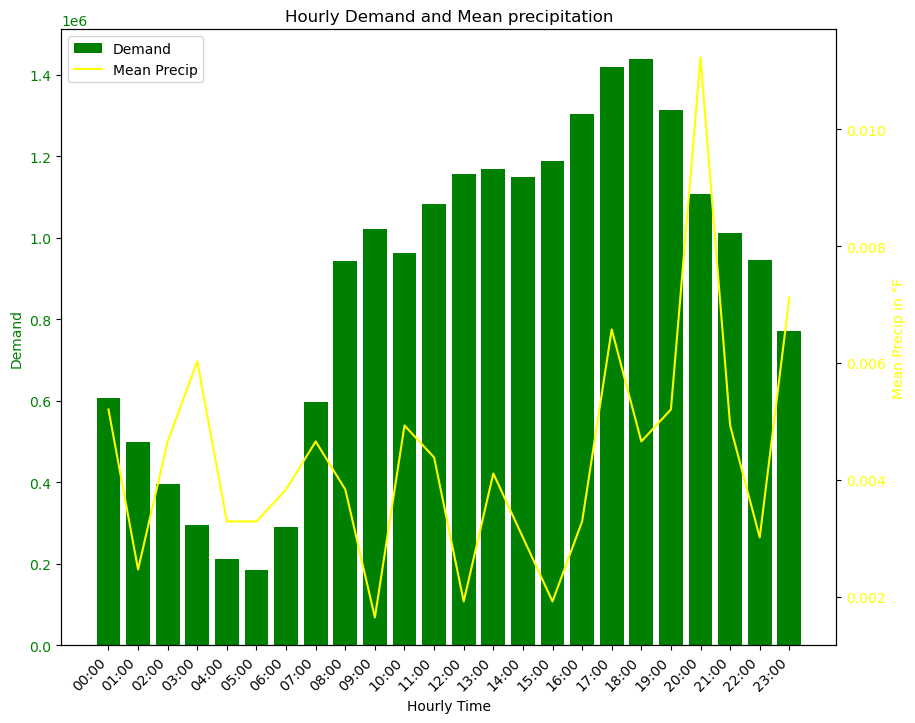

In [97]:
# Plot average hourly precip over hourly demand
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.bar(count_hourly_total['hour_format'], count_hourly_total['count'], color='green', label='Demand')
ax1.set_xlabel('Hourly Time')
ax1.set_ylabel('Demand', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()

ax2.plot(mean_precip_hourly['hourly_time'], mean_precip_hourly['precip'], color='yellow', label='Mean Precip')
ax2.set_ylabel('Mean Precip in °F', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')

xticks = range(len(count_hourly_total['hour_format']))
ax1.set_xticks(xticks)
ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45, ha='right')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=70)
plt.title('Hourly Demand and Mean precipitation')
plt.show()

In [98]:
# Calculate correlation betweend hourly demand and average hourly precip
correlation = mean_precip_hourly['precip'].corr(count_hourly_total['count'])
print(f"Correlation between the hourly temperature and hourly demand: {correlation:.2f}")

Correlation between the hourly temperature and hourly demand: 0.07


## 4.1.1.16 Impact of weather conditions on hourly Demand

In [99]:
# Aggregating based on maped weather_conditions
# (Here no rounding, as differences would be non existent=
mean_condition_hourly = hourly_weather.groupby(['hourly_time'])['condition_map'].mean().reset_index()

In [100]:
mean_condition_hourly.head()

,hourly_time,condition_map
0,00:00,1.746951
1,01:00,1.715596
2,02:00,1.660494
3,03:00,1.648148
4,04:00,1.673981


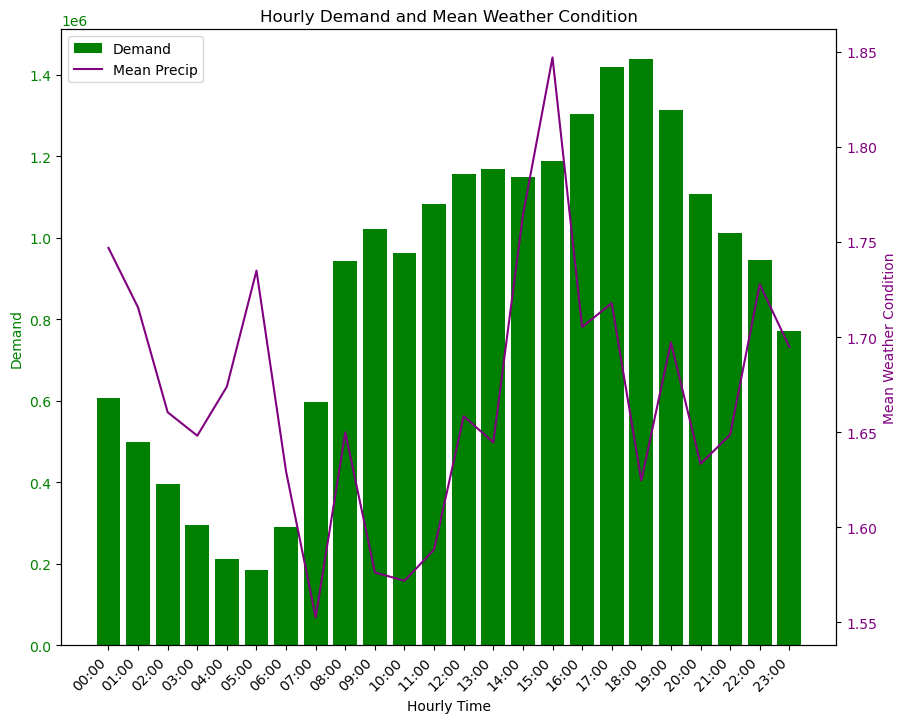

In [101]:
# Plotting average hourly weather condition over 
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.bar(count_hourly_total['hour_format'], count_hourly_total['count'], color='green', label='Demand')
ax1.set_xlabel('Hourly Time')
ax1.set_ylabel('Demand', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()

ax2.plot(mean_condition_hourly['hourly_time'], mean_condition_hourly['condition_map'], color='purple', label='Mean Precip')
ax2.set_ylabel('Mean Weather Condition', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

xticks = range(len(count_hourly_total['hour_format']))
ax1.set_xticks(xticks)
ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45, ha='right')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=70)
plt.title('Hourly Demand and Mean Weather Condition')
plt.show()

In [102]:
# Calcualting correlation between mean hourly weather condition and mean hourly demand
correlation = mean_condition_hourly['condition_map'].corr(count_hourly_total['count'])
print(f"Correlation between the hourly temperature and hourly demand: {correlation:.2f}")

Correlation between the hourly temperature and hourly demand: 0.06


## 4.1.1.17 Impact of seasons on hourly Demand

In [103]:
# Again mapping months to season, using the same mapping list
df_hourly['season'] = df_hourly['trip_start_date'].dt.month.map(seasons_map)

In [104]:
df_hourly.head()

#,trip_id,trip_start_date,trip_start_hour,isWeekend,season
0,f00546971a3e4c8ab55761a337443a0dfa33f42f,2017-01-01,0,True,Winter
1,fe9bfc25af9dffac30370f4e7d57a8c8a8bdbc0d,2017-01-01,0,True,Winter
2,149f18c2d8b9bce6001cc9e156092aa562c83bc1,2017-01-01,0,True,Winter
3,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,2017-01-01,0,True,Winter
4,f398f04efdae9641df780e0a824770a62ab9a2ea,2017-01-01,0,True,Winter
5,7f6cfe5d83d1625724b534dc1130aca455f3c46f,2017-01-01,0,True,Winter
6,d056e52f21b582d105b458a30463a1e684b9a54e,2017-01-01,0,True,Winter
7,c3ee40051c5643c54064a8b9df3686d2d411518d,2017-01-01,0,True,Winter
8,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,2017-01-01,0,True,Winter
9,bfa259279b4557566d2d06381156715d9be355a1,2017-01-01,0,True,Winter


In [105]:
# Aggregting over mapped seasons
count_hourly_season = df_hourly.groupby(by=['trip_start_hour','season']).agg({'count': vaex.agg.count('trip_id')}) 

In [106]:
count_hourly_season = count_hourly_season.to_pandas_df()
count_hourly_season.head()

,trip_start_hour,season,count
0,0,Winter,134062
1,0,Summer,176838
2,0,Fall,135888
3,0,Spring,161405
4,1,Winter,117603


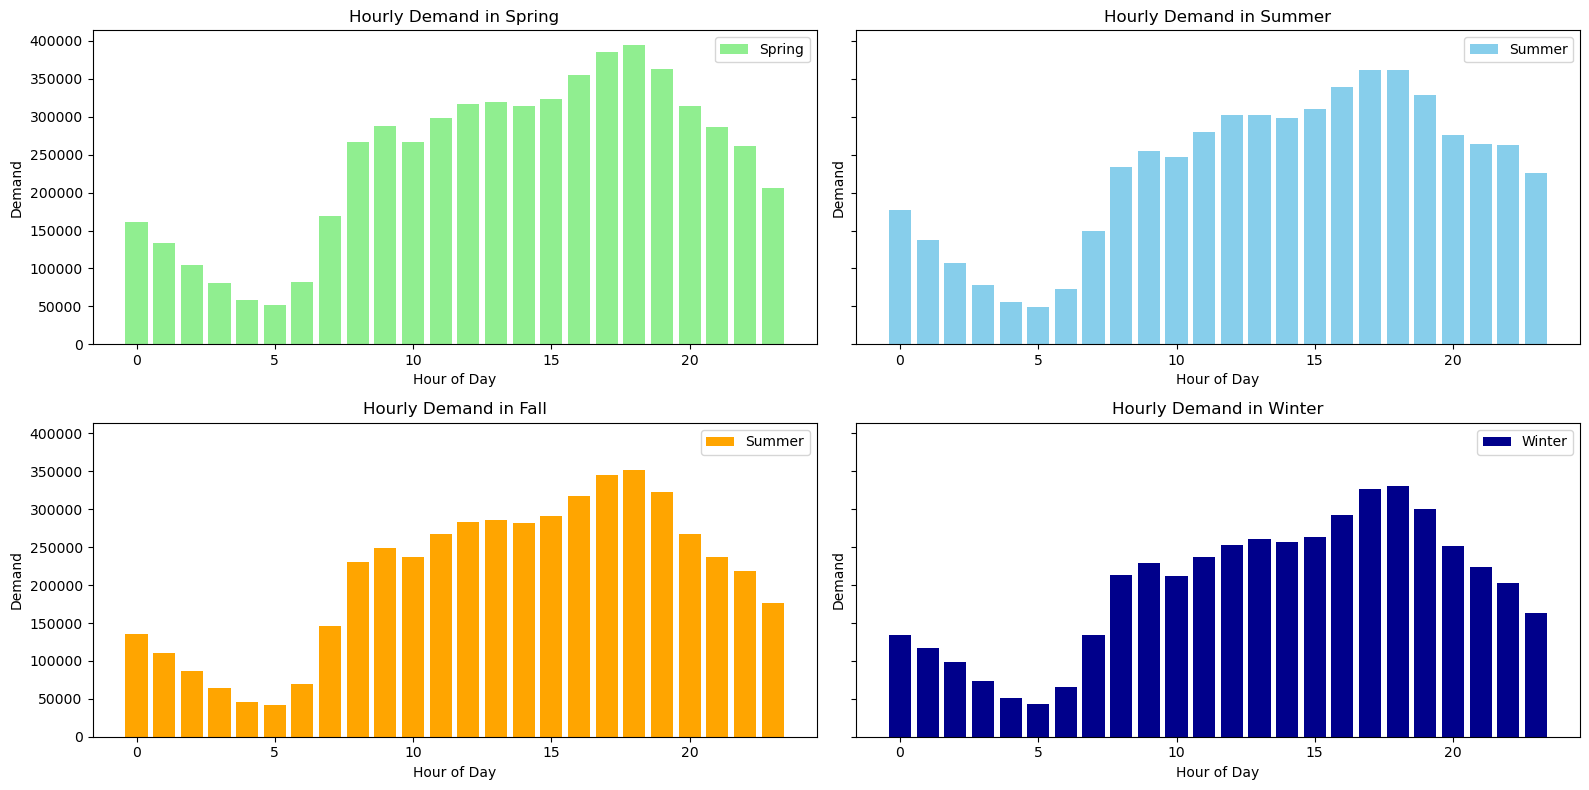

In [107]:
# Similar to weekday/weekend data, creating individual dataframes for each season (winter,spring,summer,fall)
spring_data = count_hourly_season[count_hourly_season['season'] == 'Spring']
summer_data = count_hourly_season[count_hourly_season['season'] == 'Summer']
fall_data = count_hourly_season[count_hourly_season['season'] == 'Fall']
winter_data = count_hourly_season[count_hourly_season['season'] == 'Winter']

fig, axs = plt.subplots(2,2, figsize=(16, 8), sharey=True)
axs[0, 0].bar(spring_data['trip_start_hour'], spring_data['count'], color='lightgreen', label='Spring')
axs[0, 0].set_title('Hourly Demand in Spring')
axs[0, 0].set_xlabel('Hour of Day')
axs[0, 0].set_ylabel('Demand')
axs[0, 0].legend()

axs[0, 1].bar(summer_data['trip_start_hour'], summer_data['count'], color='skyblue', label='Summer')
axs[0, 1].set_title('Hourly Demand in Summer')
axs[0, 1].set_xlabel('Hour of Day')
axs[0, 1].set_ylabel('Demand')
axs[0, 1].legend()

axs[1, 0].bar(fall_data['trip_start_hour'], fall_data['count'], color='orange', label='Summer')
axs[1, 0].set_title('Hourly Demand in Fall')
axs[1, 0].set_xlabel('Hour of Day')
axs[1, 0].set_ylabel('Demand')
axs[1, 0].legend()

axs[1, 1].bar(winter_data['trip_start_hour'], winter_data['count'], color='darkblue', label='Winter')
axs[1, 1].set_title('Hourly Demand in Winter')
axs[1, 1].set_xlabel('Hour of Day')
axs[1, 1].set_ylabel('Demand')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## 4.1.1.18 Changes of financial metrics in comparison to yearly demand

In [108]:
trip_counts_date.head()

,trip_start_date,count,isHoliday,isWeekend,weekday,season,weekday_name,month
0,2017-01-01,48738,True,True,6,Winter,Sunday,1
1,2017-01-02,27182,True,False,0,Winter,Monday,1
2,2017-01-03,41944,False,False,1,Winter,Tuesday,1
3,2017-01-04,52079,False,False,2,Winter,Wednesday,1
4,2017-01-05,62229,False,False,3,Winter,Thursday,1


In [109]:
# Aggregating fares by date
sum_fares= df.groupby(by='trip_start_date').agg({'sum_fare': vaex.agg.sum('fare')})

In [110]:
# Aggregating tips by date
sum_tips = df.groupby(by='trip_start_date').agg({'sum_tips': vaex.agg.sum('tips')})

In [111]:
# Aggregating tolls by date
sum_tolls = df.groupby(by='trip_start_date').agg({'sum_tolls': vaex.agg.sum('tolls')})

In [112]:
# Aggregating extras by date
sum_extras = df.groupby(by='trip_start_date').agg({'sum_extras': vaex.agg.sum('extras')})

In [113]:
# Aggregating totals by date
sum_totals = df.groupby(by='trip_start_date').agg({'sum_totals': vaex.agg.sum('trip_total')})

In [114]:
sum_totals.head()

#,trip_start_date,sum_totals
0,2017-02-20,673446
1,2017-01-18,848172
2,2017-09-23,775002
3,2017-08-14,832864
4,2017-03-26,851788
5,2017-09-13,1.16001e+06
6,2017-11-01,1.02949e+06
7,2017-02-28,887053
8,2017-01-02,487710
9,2017-04-13,1.09248e+06


In [115]:
# Sorting every created financial dataframe, by date to have continuous curves in the plot
sum_fares = sum_fares.to_pandas_df()
sum_fares = sum_fares.sort_values(by=['trip_start_date'])

sum_tips = sum_tips.to_pandas_df()
sum_tips = sum_tips.sort_values(by=['trip_start_date'])

sum_tolls = sum_tolls.to_pandas_df()
sum_tolls = sum_tolls.sort_values(by=['trip_start_date'])

sum_extras = sum_extras.to_pandas_df()
sum_extras = sum_extras.sort_values(by=['trip_start_date'])

sum_totals = sum_totals.to_pandas_df()
sum_totals = sum_totals.sort_values(by=['trip_start_date'])

In [116]:
# merging all data together into one dataframe, to centralize it and make plotting easier
sum_finance = pd.merge(sum_fares, sum_tips, on='trip_start_date', how='outer')
sum_finance = pd.merge(sum_finance, sum_tolls, on='trip_start_date', how='outer')
sum_finance = pd.merge(sum_finance, sum_extras, on='trip_start_date', how='outer')
sum_finance = pd.merge(sum_finance, sum_totals, on='trip_start_date', how='outer')

In [117]:
# again sort by date
sum_finance = sum_finance.sort_values(by=['trip_start_date'])
sum_finance.head()

,trip_start_date,sum_fare,sum_tips,sum_tolls,sum_extras,sum_totals
0,2017-01-01,606382.58,54852.15,54.00,49078.17,713855.90
1,2017-01-02,408679.56,39860.15,21.20,36894.14,487710.05
2,2017-01-03,546333.45,54406.86,8.00,31443.93,635919.74
3,2017-01-04,628948.41,65663.48,25.06,29201.05,728617.50
4,2017-01-05,786368.43,89000.35,4.00,47262.36,928891.26


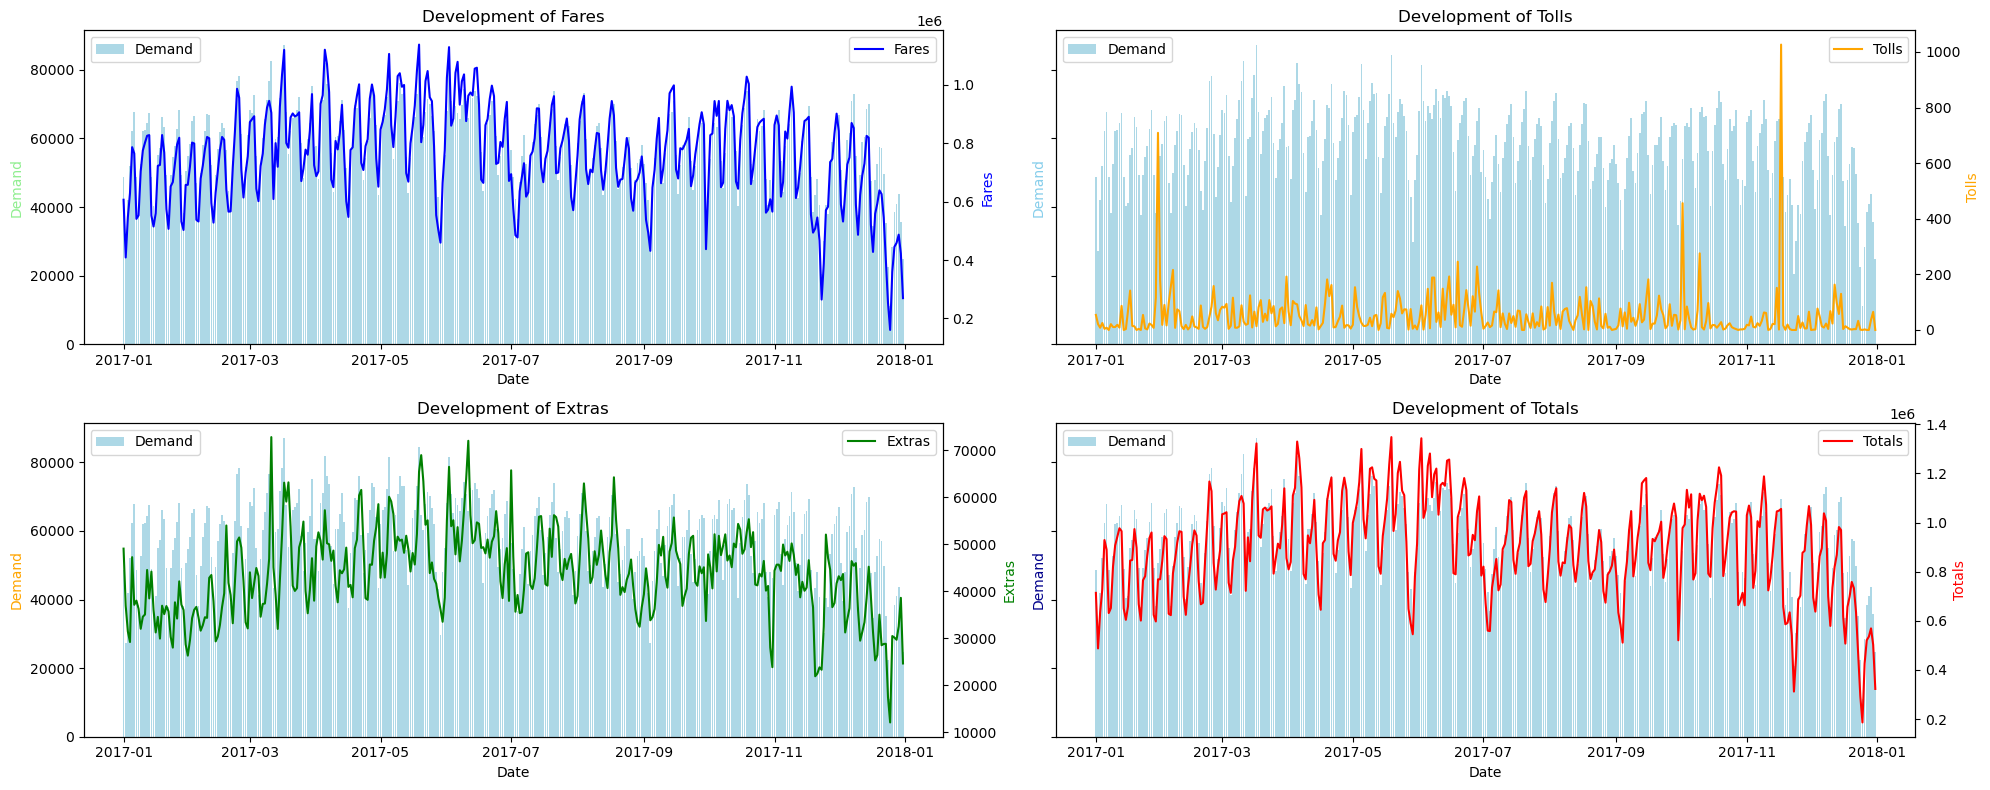

In [118]:
# We now four plots that track the development of fares, tolls, extras and totals in comparison to the demand
# Here we always create two subplots (ax1 and ax2) since we need to different scales for demand and the metric
# If we would not do that the metric's plot would not be visible due to its comparetively low values in comparison to the demand valeus
# The do subplots help us create fitting scales

fig, axs = plt.subplots(2, 2, figsize=(20, 8), sharey=True)

# Plot for Fares
ax1 = axs[0, 0]
ax2 = ax1.twinx()
ax1.bar(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance['trip_start_date'], sum_finance['sum_fare'], color='blue', label='Fares')
ax1.set_title('Development of Fares')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='lightgreen')
ax2.set_ylabel('Fares', color='blue')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Tolls
ax1 = axs[0, 1]
ax2 = ax1.twinx()
ax1.bar(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance['trip_start_date'], sum_finance['sum_tolls'], color='orange', label='Tolls')
ax1.set_title('Development of Tolls')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='skyblue')
ax2.set_ylabel('Tolls', color='orange')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Extras
ax1 = axs[1, 0]
ax2 = ax1.twinx()
ax1.bar(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance['trip_start_date'], sum_finance['sum_extras'], color='green', label='Extras')
ax1.set_title('Development of Extras')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='orange')
ax2.set_ylabel('Extras', color='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Totals
ax1 = axs[1, 1]
ax2 = ax1.twinx()
ax1.bar(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance['trip_start_date'], sum_finance['sum_totals'], color='red', label='Totals')
ax1.set_title('Development of Totals')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='darkblue')
ax2.set_ylabel('Totals', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [119]:
#copying trip_counts_date, drop all for this operation unnessecary columns
demand_df_slim = trip_counts_date[['trip_start_date', 'count']].copy()
#merge trip_counts_date (demand df) and sum_finance (metrics df) 
df_corr_demand_metrics = pd.merge(demand_df_slim, sum_finance, on='trip_start_date', how='outer')

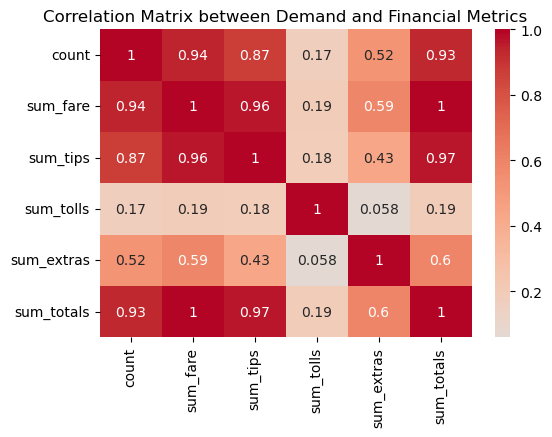

In [120]:
#calculate correlation matrix
corr_matrix = df_corr_demand_metrics.corr()
#visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix between Demand and Financial Metrics')
plt.show()

## 4.1.1.19 Changes of financial metrics in comparison to hourly demand

In [121]:
# Performing the same analysis, but instead of the total year demand, we inspect the hourly demand
df_hourly_fin = df[['trip_id','trip_start_date','trip_start_hour','fare','tips','tolls','extras','trip_total']]

In [122]:
df_hourly_fin.head()

#,trip_id,trip_start_date,trip_start_hour,fare,tips,tolls,extras,trip_total
0,f00546971a3e4c8ab55761a337443a0dfa33f42f,2017-01-01,0,13.25,4.25,0,1,18.5
1,fe9bfc25af9dffac30370f4e7d57a8c8a8bdbc0d,2017-01-01,0,10,2,0,0,12
2,149f18c2d8b9bce6001cc9e156092aa562c83bc1,2017-01-01,0,4.5,0,0,0,4.5
3,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,2017-01-01,0,6.25,0,0,0,6.25
4,f398f04efdae9641df780e0a824770a62ab9a2ea,2017-01-01,0,6,0,0,0,6
5,7f6cfe5d83d1625724b534dc1130aca455f3c46f,2017-01-01,0,5.5,0,0,1,6.5
6,d056e52f21b582d105b458a30463a1e684b9a54e,2017-01-01,0,9.75,0,0,1,10.75
7,c3ee40051c5643c54064a8b9df3686d2d411518d,2017-01-01,0,22.75,4.85,0,1.5,29.1
8,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,2017-01-01,0,12.25,2.85,0,2,17.1
9,bfa259279b4557566d2d06381156715d9be355a1,2017-01-01,0,11.25,0,0,1,12.25


In [123]:
sum_fares_hour= df.groupby(by='trip_start_hour').agg({'sum_fare': vaex.agg.sum('fare')})

In [124]:
sum_tips_hour= df.groupby(by='trip_start_hour').agg({'sum_tips': vaex.agg.sum('tips')})

In [125]:
sum_tolls_hour= df.groupby(by='trip_start_hour').agg({'sum_tolls': vaex.agg.sum('tolls')})

In [126]:
sum_extras_hour= df.groupby(by='trip_start_hour').agg({'sum_extras': vaex.agg.sum('extras')})

In [127]:
sum_totals_hour= df.groupby(by='trip_start_hour').agg({'sum_total': vaex.agg.sum('trip_total')})

In [128]:
sum_fares_hour = sum_fares_hour.to_pandas_df()
sum_fares_hour = sum_fares_hour.sort_values(by=['trip_start_hour'])

sum_tips_hour = sum_tips_hour.to_pandas_df()
sum_tips_hour = sum_tips_hour.sort_values(by=['trip_start_hour'])

sum_tolls_hour = sum_tolls_hour.to_pandas_df()
sum_tolls_hour = sum_tolls_hour.sort_values(by=['trip_start_hour'])

sum_extras_hour = sum_extras_hour.to_pandas_df()
sum_extras_hour = sum_extras_hour.sort_values(by=['trip_start_hour'])

sum_totals_hour = sum_totals_hour.to_pandas_df()
sum_totals_hour = sum_totals_hour.sort_values(by=['trip_start_hour'])

In [129]:
sum_finance_hour = pd.merge(sum_fares_hour, sum_tips_hour, on='trip_start_hour', how='outer')
sum_finance_hour = pd.merge(sum_finance_hour, sum_tolls_hour, on='trip_start_hour', how='outer')
sum_finance_hour = pd.merge(sum_finance_hour, sum_extras_hour, on='trip_start_hour', how='outer')
sum_finance_hour = pd.merge(sum_finance_hour, sum_totals_hour, on='trip_start_hour', how='outer')

In [130]:
sum_finance_hour.head()

,trip_start_hour,sum_fare,sum_tips,sum_tolls,sum_extras,sum_total
0,0,7286243.10,810327.89,409.40,549800.24,8700039.73
1,1,5489192.33,609001.10,498.40,431936.95,6575623.75
2,2,4159064.60,446761.96,216.60,307682.82,4947565.18
3,3,3351440.63,333062.05,164.36,223071.65,3930533.40
4,4,3228077.80,308542.43,360.29,143344.42,3695526.69


In [131]:
count_hourly_slim = count_hourly_total[['trip_start_hour','count']].copy()

In [132]:
count_hourly_slim.head()

,trip_start_hour,count
0,0,608193
1,1,500091
2,2,396749
3,3,296660
4,4,211405


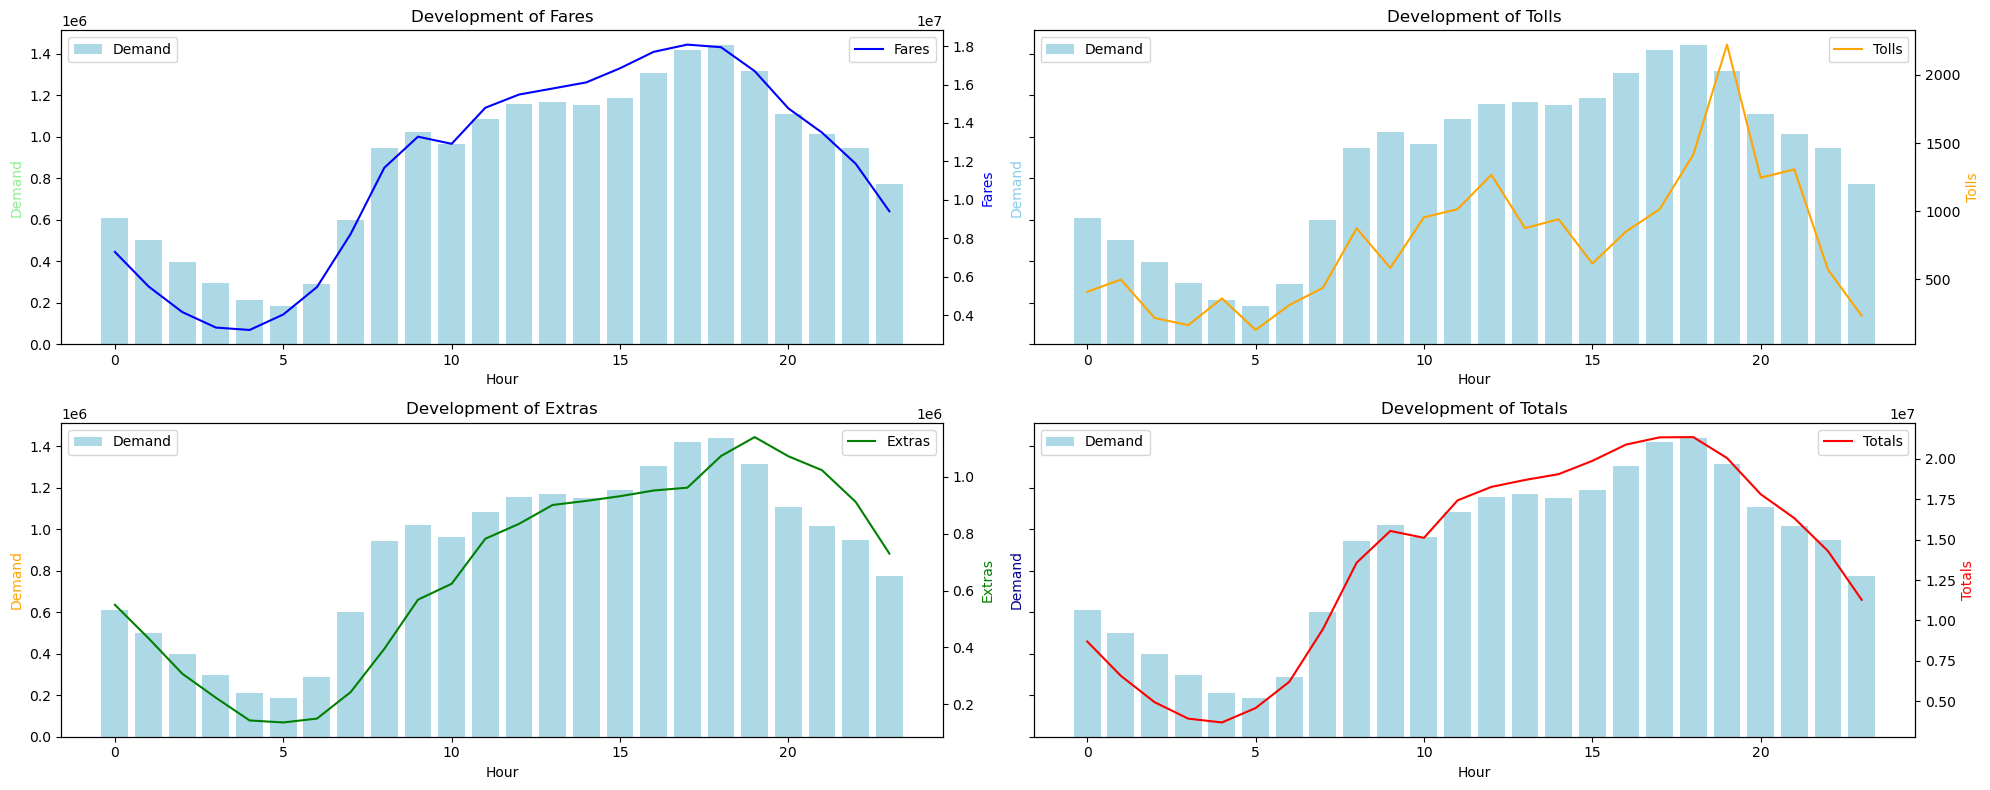

In [133]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8), sharey=True)

# Plot for Fares
ax1 = axs[0, 0]
ax2 = ax1.twinx()
ax1.bar(count_hourly_slim['trip_start_hour'], count_hourly_slim['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance_hour['trip_start_hour'], sum_finance_hour['sum_fare'], color='blue', label='Fares')
ax1.set_title('Development of Fares')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='lightgreen')
ax2.set_ylabel('Fares', color='blue')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Tolls
ax1 = axs[0, 1]
ax2 = ax1.twinx()
ax1.bar(count_hourly_slim['trip_start_hour'], count_hourly_slim['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance_hour['trip_start_hour'], sum_finance_hour['sum_tolls'], color='orange', label='Tolls')
ax1.set_title('Development of Tolls')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='skyblue')
ax2.set_ylabel('Tolls', color='orange')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Extras
ax1 = axs[1, 0]
ax2 = ax1.twinx()
ax1.bar(count_hourly_slim['trip_start_hour'], count_hourly_slim['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance_hour['trip_start_hour'], sum_finance_hour['sum_extras'], color='green', label='Extras')
ax1.set_title('Development of Extras')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='orange')
ax2.set_ylabel('Extras', color='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Totals
ax1 = axs[1, 1]
ax2 = ax1.twinx()
ax1.bar(count_hourly_slim['trip_start_hour'], count_hourly_slim['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance_hour['trip_start_hour'], sum_finance_hour['sum_total'], color='red', label='Totals')
ax1.set_title('Development of Totals')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='darkblue')
ax2.set_ylabel('Totals', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

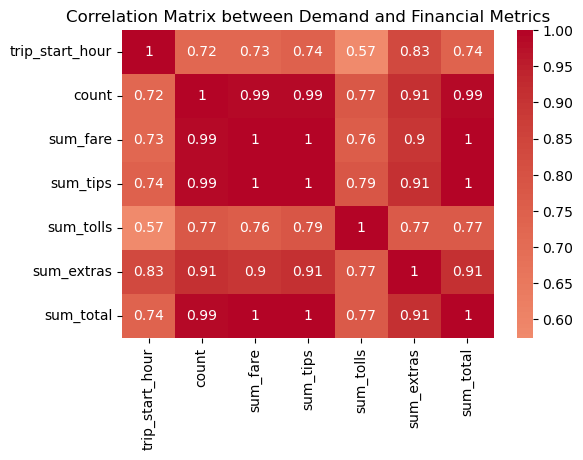

In [134]:
df_corr_hour = pd.merge(count_hourly_slim, sum_finance_hour, on='trip_start_hour', how='outer')
corr_matrix_hour = df_corr_hour.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_hour, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix between Demand and Financial Metrics')
plt.show()